# P3HPC '24: Top Down and Hierarchical Clustering on the RAJA Performance Suite: Thicket Tutorial

In this notebook, we compose performance data from experiments using the RAJA Performance Suite on various hardware:

- AMD MI-250X GPUs on LLNL's Tioga system
- NVIDIA V100 GPUs on LLNL's Lassen system
- Intel Sapphire Rapids CPUs, DDR nodes on LLNL's Poodle
- Intel Sapphire Rapids CPUS, HBM nodes on LLNL's Poodle

We reproduce some of the analysis and visualizations from the paper:

Olga Pearce, Jason Burmark, Rich Hornung, Befikir Bogale, Ian Lumsden, Michael McKinsey, Dewi Yokelson, David Boehme, 
Stephanie Brink, Michela Taufer, and Tom Scogland. “RAJA Performance Suite: Performance Portability Analysis with 
Caliper and Thicket”. SC-W 2024: Workshops of ACM/IEEE International Conference for High Performance Computing, 
Networking, Storage, and Analysis. Performance, Portability & Productivity in HPC. 2024.

## 1. Import Necessary Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as sk
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram
from scipy import stats

import thicket as tt

## 2. Define Kernels to Analyze

Define the sets of kernels to select for each tuning, separated by mi250x/v100 and Sapphire Rapids.

In [2]:
mi250x_v100_kernels = {
    "block_256": [
        "Algorithm_ATOMIC",
        "Algorithm_MEMCPY",
        "Algorithm_MEMSET",
        "Apps_DEL_DOT_VEC_2D",
        "Apps_EDGE3D",
        "Apps_ENERGY",
        "Apps_FIR",
        "Apps_LTIMES",
        "Apps_LTIMES_NOVIEW",
        "Apps_MATVEC_3D_STENCIL",
        "Apps_NODAL_ACCUMULATION_3D",
        "Apps_PRESSURE",
        "Apps_VOL3D",
        "Apps_ZONAL_ACCUMULATION_3D",
        "Basic_ARRAY_OF_PTRS",
        "Basic_COPY8",
        "Basic_DAXPY",
        "Basic_DAXPY_ATOMIC",
        "Basic_IF_QUAD",
        "Basic_INDEXLIST",
        "Basic_INDEXLIST_3LOOP",
        "Basic_INIT3",
        "Basic_INIT_VIEW1D",
        "Basic_INIT_VIEW1D_OFFSET",
        "Basic_MAT_MAT_SHARED",
        "Basic_MULADDSUB",
        "Basic_NESTED_INIT",
        "Basic_PI_ATOMIC",
        "Comm_HALO_EXCHANGE",
        "Comm_HALO_PACKING",
        "Comm_HALO_SENDRECV",
        "Lcals_DIFF_PREDICT",
        "Lcals_EOS",
        "Lcals_FIRST_DIFF",
        "Lcals_FIRST_SUM",
        "Lcals_GEN_LIN_RECUR",
        "Lcals_HYDRO_1D",
        "Lcals_HYDRO_2D",
        "Lcals_INT_PREDICT",
        "Lcals_PLANCKIAN",
        "Lcals_TRIDIAG_ELIM",
        "Polybench_2MM",
        "Polybench_3MM",
        "Polybench_ADI",
        "Polybench_ATAX",
        "Polybench_FDTD_2D",
        "Polybench_FLOYD_WARSHALL",
        "Polybench_GEMM",
        "Polybench_GEMVER",
        "Polybench_GESUMMV",
        "Polybench_HEAT_3D",
        "Polybench_JACOBI_1D",
        "Polybench_JACOBI_2D",
        "Polybench_MVT",
        "Stream_ADD",
        "Stream_COPY",
        "Stream_MUL",
        "Stream_TRIAD",
    ], # For block_256
    "default": [
        "Algorithm_SORT",
        "Algorithm_SORTPAIRS",
    ], # For default
    "blkatm_occgs_256": [
        "Algorithm_REDUCE_SUM",
        "Basic_PI_REDUCE",
        "Basic_REDUCE3_INT",
        "Basic_REDUCE_STRUCT",
        "Basic_TRAP_INT",
        "Stream_DOT",
    ], # For blkatm_occgs_256
    "block_64": [
        "Apps_CONVECTION3DPA",
        "Apps_DIFFUSION3DPA",
        "Apps_MASS3DEA",
    ], # For block_64
    "block_25": [
        "Apps_MASS3DPA",
    ], # For block_25
    "funcptr_256": [
        "Comm_HALO_EXCHANGE_FUSED",
        "Comm_HALO_PACKING_FUSED",
    ], # For funcptr_256
    "rocprim": [
        "Algorithm_SCAN",
    ], # For rocprim
    "atomic_occgs_256": [
        "Algorithm_HISTOGRAM",
        "Basic_MULTI_REDUCE",
    ], # For atomic_occgs_256
    "blkdev_occgs_256": [
        "Lcals_FIRST_MIN",
    ], # For blkdev_occgs_256
    "cub": [
        "Algorithm_SCAN",
    ], # For cub
}

spr_kernels = {
    "default": [
        "Algorithm_ATOMIC",
        "Algorithm_HISTOGRAM",
        "Algorithm_MEMCPY",
        "Algorithm_MEMSET",
        "Algorithm_SCAN",
        "Algorithm_SORT",
        "Algorithm_SORTPAIRS",
        "Algorithm_REDUCE_SUM",
        "Apps_CONVECTION3DPA",
        "Apps_DEL_DOT_VEC_2D",
        "Apps_DIFFUSION3DPA",
        "Apps_EDGE3D",
        "Apps_ENERGY",
        "Apps_FIR",
        "Apps_LTIMES",
        "Apps_LTIMES_NOVIEW",
        "Apps_MASS3DEA",
        "Apps_MASS3DPA",
        "Apps_MATVEC_3D_STENCIL",
        "Apps_NODAL_ACCUMULATION_3D",
        "Apps_PRESSURE",
        "Apps_VOL3D",
        "Apps_ZONAL_ACCUMULATION_3D",
        "Basic_ARRAY_OF_PTRS",
        "Basic_COPY8",
        "Basic_DAXPY",
        "Basic_DAXPY_ATOMIC",
        "Basic_IF_QUAD",
        "Basic_INDEXLIST",
        "Basic_INDEXLIST_3LOOP",
        "Basic_INIT3",
        "Basic_INIT_VIEW1D",
        "Basic_INIT_VIEW1D_OFFSET",
        "Basic_MAT_MAT_SHARED",
        "Basic_MULADDSUB",
        "Basic_MULTI_REDUCE",
        "Basic_NESTED_INIT",
        "Basic_PI_ATOMIC",
        "Basic_PI_REDUCE",
        "Basic_REDUCE_STRUCT",
        "Basic_REDUCE3_INT",
        "Basic_TRAP_INT",
        "Comm_HALO_EXCHANGE",
        "Comm_HALO_PACKING",
        "Comm_HALO_SENDRECV",
        "Lcals_DIFF_PREDICT",
        "Lcals_EOS",
        "Lcals_FIRST_DIFF",
        "Lcals_FIRST_MIN",
        "Lcals_FIRST_SUM",
        "Lcals_GEN_LIN_RECUR",
        "Lcals_HYDRO_1D",
        "Lcals_HYDRO_2D",
        "Lcals_INT_PREDICT",
        "Lcals_PLANCKIAN",
        "Lcals_TRIDIAG_ELIM",
        "Polybench_2MM",
        "Polybench_3MM",
        "Polybench_ADI",
        "Polybench_ATAX",
        "Polybench_FDTD_2D",
        "Polybench_FLOYD_WARSHALL",
        "Polybench_GEMM",
        "Polybench_GEMVER",
        "Polybench_GESUMMV",
        "Polybench_HEAT_3D",
        "Polybench_JACOBI_1D",
        "Polybench_JACOBI_2D",
        "Polybench_MVT",
        "Stream_ADD",
        "Stream_COPY",
        "Stream_DOT",
        "Stream_MUL",
        "Stream_TRIAD",
    ], # default
    "funcptr": [
        "Comm_HALO_EXCHANGE_FUSED",
        "Comm_HALO_PACKING_FUSED",
    ], # For funcptr
}

# List of kernels to exclude from the data, agnostic of parameters
exclude_kernels = [
    "Algorithm_ATOMIC",
    "Basic_INDEXLIST",
    "Comm_HALO_EXCHANGE",
    "Comm_HALO_EXCHANGE_FUSED",
    "Comm_HALO_SENDRECV",
]

In [3]:
def kernel_query(kernel_list):
    return tt.query.Query().match(
        ".",
        lambda row: row["name"].apply(
            lambda n: n in kernel_list
        ).all()
    ).rel("*")

def not_kernel_query(kernel_list):
    return tt.query.Query().match(
        ".",
        lambda row: row["name"].apply(
            lambda n: n not in kernel_list
        ).all()
    ).rel("*")

## 3. Read Performance Data into Thicket

In [4]:
# Directories
main_dir = "../data/topdown_metrics/"
epyc_mi250x_dir = main_dir + "epyc-mi250x/"
p9_v100_dir = main_dir + "p9-v100/"
spr_ddr_dir = main_dir + "spr-ddr/"
spr_hbm_dir = main_dir + "spr-hbm/"

tk_mi250x = tt.Thicket.from_caliperreader(glob(epyc_mi250x_dir + "**/*.cali", recursive=True), fill_perfdata=False)
tk_v100 = tt.Thicket.from_caliperreader(glob(p9_v100_dir + "**/*.cali", recursive=True), fill_perfdata=False)
tk_spr_ddr = tt.Thicket.from_caliperreader(glob(spr_ddr_dir + "**/*.cali", recursive=True), fill_perfdata=False)
tk_spr_hbm = tt.Thicket.from_caliperreader(glob(spr_hbm_dir + "**/*.cali", recursive=True), fill_perfdata=False)

print("epyc-mi250x: ", len(tk_mi250x.profile), " files")
print("p9-v100: ", len(tk_v100.profile), " files")
print("spr-ddr: ", len(tk_spr_ddr.profile), " files")
print("spr-hbm: ", len(tk_spr_hbm.profile), " files")

(2/2) Creating Thicket: 100%|██████████| 39/39 [00:00<00:00, 46.09it/s]

epyc-mi250x:  90  files
p9-v100:  90  files
spr-ddr:  40  files
spr-hbm:  40  files


## 4. Compose Performance Data in Thicket

### 4.1 Groupby parameters to apply kernel queries for each tuning

In [5]:
gb_params = ["variant", "tuning"]
gb_mi250x = tk_mi250x.groupby(gb_params)
gb_v100 = tk_v100.groupby(gb_params)
gb_spr_ddr = tk_spr_ddr.groupby(gb_params + ["spot:topdown.all"])
gb_spr_hbm = tk_spr_hbm.groupby(gb_params + ["spot:topdown.all"])

In [6]:
new_gb_mi250x = {}
new_gb_v100 = {}
gb_spr_ddr_topdown = {}
gb_spr_ddr_notopdown = {}
gb_spr_hbm_topdown = {}
gb_spr_hbm_notopdown = {}

print("mi250x")
for k in gb_mi250x.keys():
    print("\t", k)
    new_gb_mi250x[k] = gb_mi250x[k].query(kernel_query(mi250x_v100_kernels[k[1]]), multi_index_mode="all").query(not_kernel_query(exclude_kernels), multi_index_mode="all")
    
print("v100")
for k in gb_v100.keys():
    print("\t", k)
    new_gb_v100[k] = gb_v100[k].query(kernel_query(mi250x_v100_kernels[k[1]]), multi_index_mode="all").query(not_kernel_query(exclude_kernels), multi_index_mode="all")

print("spr-ddr")
for key in gb_spr_ddr.keys():
    print("\t", key)
    if key[2] == "true":
        gb_spr_ddr_topdown[key] = gb_spr_ddr[key].query(kernel_query(spr_kernels[key[1]]), multi_index_mode="all").query(not_kernel_query(exclude_kernels), multi_index_mode="all")
    else:
        gb_spr_ddr_notopdown[key] = gb_spr_ddr[key].query(kernel_query(spr_kernels[key[1]]), multi_index_mode="all").query(not_kernel_query(exclude_kernels), multi_index_mode="all")

        print("spr-hbm")
for key in gb_spr_hbm.keys():
    print("\t", key)
    if key[2] == "true":
        gb_spr_hbm_topdown[key] = gb_spr_hbm[key].query(kernel_query(spr_kernels[key[1]]), multi_index_mode="all").query(not_kernel_query(exclude_kernels), multi_index_mode="all")
    else:
        gb_spr_hbm_notopdown[key] = gb_spr_hbm[key].query(kernel_query(spr_kernels[key[1]]), multi_index_mode="all").query(not_kernel_query(exclude_kernels), multi_index_mode="all")

mi250x
	 ('RAJA_HIP', 'atomic_occgs_256')
	 ('RAJA_HIP', 'blkatm_occgs_256')
	 ('RAJA_HIP', 'blkdev_occgs_256')
	 ('RAJA_HIP', 'block_25')
	 ('RAJA_HIP', 'block_256')
	 ('RAJA_HIP', 'block_64')
	 ('RAJA_HIP', 'default')
	 ('RAJA_HIP', 'funcptr_256')
	 ('RAJA_HIP', 'rocprim')
v100
	 ('RAJA_CUDA', 'atomic_occgs_256')
	 ('RAJA_CUDA', 'blkatm_occgs_256')
	 ('RAJA_CUDA', 'blkdev_occgs_256')
	 ('RAJA_CUDA', 'block_25')
	 ('RAJA_CUDA', 'block_256')
	 ('RAJA_CUDA', 'block_64')
	 ('RAJA_CUDA', 'cub')
	 ('RAJA_CUDA', 'default')
	 ('RAJA_CUDA', 'funcptr_256')
spr-ddr
	 ('RAJA_Seq', 'default', 'true')
	 ('RAJA_Seq', 'default', nan)
spr-hbm
	 ('RAJA_Seq', 'funcptr', 'true')
	 ('RAJA_Seq', 'funcptr', nan)
spr-hbm
	 ('RAJA_Seq', 'default', 'true')
	 ('RAJA_Seq', 'default', nan)
	 ('RAJA_Seq', 'funcptr', 'true')
	 ('RAJA_Seq', 'funcptr', nan)


### 4.2 Compose Thickets after applying queries

We have separate Thickets for mi250x, v100, and the combination for Sapphire Rapids on DDR/HBM and topdown/no-topdown. We calculate statistics for each of these Thickets separately.

In [7]:
tk_mi250x = tt.Thicket.concat_thickets(list(new_gb_mi250x.values()), fill_perfdata=False)
tk_v100 = tt.Thicket.concat_thickets(list(new_gb_v100.values()), fill_perfdata=False)
tk_spr_ddr_topdown = tt.Thicket.concat_thickets(list(gb_spr_ddr_topdown.values()), fill_perfdata=False)
tk_spr_ddr_notopdown = tt.Thicket.concat_thickets(list(gb_spr_ddr_notopdown.values()), fill_perfdata=False)
tk_spr_hbm_topdown = tt.Thicket.concat_thickets(list(gb_spr_hbm_topdown.values()), fill_perfdata=False)
tk_spr_hbm_notopdown = tt.Thicket.concat_thickets(list(gb_spr_hbm_notopdown.values()), fill_perfdata=False)

types = ["mi250x", "v100", "ddr_topdown", "ddr", "hbm_topdown", "hbm"]
tks = [
    tk_mi250x,
    tk_v100,
    tk_spr_ddr_topdown,
    tk_spr_ddr_notopdown,
    tk_spr_hbm_topdown,
    tk_spr_hbm_notopdown,
]
tkmap = dict(zip(types, tks))

## 5. Calculate Derived Metrics

### 5.1 Define metrics names

In [8]:
# Primary time metrics
ddr_no_topdown_time_metric = ("ddr", "Avg time/rank")
hbm_no_topdown_time_metric = ("hbm", "Avg time/rank")
mi250x_time_metric = ("mi250x", "Avg time/rank")
v100_time_metric = ("v100", "Avg time/rank")

# RAJAPerf metrics used for Memory Bandwidth for DDR and HBM
ddr_reps = ("ddr", "Reps")
ddr_bytes_read_per_rep = ("ddr", "BytesRead/Rep")
ddr_bytes_write_per_rep = ("ddr", "BytesWritten/Rep")
ddr_bytes_atomic_write_per_rep = ("ddr", "BytesAtomicModifyWritten/Rep")
ddr_flops_per_rep = ("ddr", "Flops/Rep")
ddr_tsteps = ("ddr", "tsteps")

hbm_reps = ("hbm", "Reps")
hbm_bytes_read_per_rep = ("hbm", "BytesRead/Rep")
hbm_bytes_write_per_rep = ("hbm", "BytesWritten/Rep")
hbm_bytes_atomic_write_per_rep = ("hbm", "BytesAtomicModifyWritten/Rep")
hbm_flops_per_rep = ("hbm", "Flops/Rep")
hbm_tsteps = ("hbm", "tsteps")

mi250x_reps = ("mi250x", "Reps")
mi250x_bytes_read_per_rep = ("mi250x", "BytesRead/Rep")
mi250x_bytes_write_per_rep = ("mi250x", "BytesWritten/Rep")
mi250x_bytes_atomic_write_per_rep = ("mi250x", "BytesAtomicModifyWritten/Rep")
mi250x_flops_per_rep = ("mi250x", "Flops/Rep")
mi250x_tsteps = ("mi250x", "tsteps")

v100_reps = ("v100", "Reps")
v100_bytes_read_per_rep = ("v100", "BytesRead/Rep")
v100_bytes_write_per_rep = ("v100", "BytesWritten/Rep")
v100_bytes_atomic_write_per_rep = ("v100", "BytesAtomicModifyWritten/Rep")
v100_flops_per_rep = ("v100", "Flops/Rep")
v100_tsteps = ("v100", "tsteps")

# Topdown metrics for DDR and HBM
ddr_be_bound = ("ddr_topdown", "Backend bound")
ddr_mem_bound = ("ddr_topdown", "Memory bound")
ddr_core_bound = ("ddr_topdown", "Core bound")
ddr_fe_bound = ("ddr_topdown", "Frontend bound")
ddr_fe_lat = ("ddr_topdown", "Frontend latency")
ddr_fe_bw = ("ddr_topdown", "Frontend bandwidth")
ddr_bad_spec = ("ddr_topdown", "Bad speculation")
ddr_br_mispred = ("ddr_topdown", "Branch mispredict")
ddr_machine_clears = ("ddr_topdown", "Machine clears")
ddr_retiring = ("ddr_topdown", "Retiring")
ddr_heavy_ops = ("ddr_topdown", "Heavy operations")
ddr_light_ops = ("ddr_topdown", "Light operations")

hbm_be_bound = ("hbm_topdown", "Backend bound")
hbm_mem_bound = ("hbm_topdown", "Memory bound")
hbm_core_bound = ("hbm_topdown", "Core bound")
hbm_fe_bound = ("hbm_topdown", "Frontend bound")
hbm_fe_lat = ("hbm_topdown", "Frontend latency")
hbm_fe_bw = ("hbm_topdown", "Frontend bandwidth")
hbm_bad_spec = ("hbm_topdown", "Bad speculation")
hbm_br_mispred = ("hbm_topdown", "Branch mispredict")
hbm_machine_clears = ("hbm_topdown", "Machine clears")
hbm_retiring = ("hbm_topdown", "Retiring")
hbm_heavy_ops = ("hbm_topdown", "Heavy operations")
hbm_light_ops = ("hbm_topdown", "Light operations")

ddr_problem_size = ("ddr", "ProblemSize")
hbm_problem_size = ("hbm", "ProblemSize")
mi250x_problem_size = ("mi250x", "ProblemSize")
v100_problem_size = ("v100", "ProblemSize")

# Configurable derived metrics
ddr_bytes_read_per_rep_scaled = ("ddr", "Bytes Read/Rep/Problem Size")
hbm_bytes_read_per_rep_scaled = ("hbm", "Bytes Read/Rep/Problem Size")
mi250x_bytes_read_per_rep_scaled = ("mi250x", "Bytes Read/Rep/Problem Size")
v100_bytes_read_per_rep_scaled = ("v100", "Bytes Read/Rep/Problem Size")

ddr_bytes_write_per_rep_scaled = ("ddr", "Bytes Written/Rep/Problem Size")
hbm_bytes_write_per_rep_scaled = ("hbm", "Bytes Written/Rep/Problem Size")
mi250x_bytes_write_per_rep_scaled = ("mi250x", "Bytes Written/Rep/Problem Size")
v100_bytes_write_per_rep_scaled = ("v100", "Bytes Written/Rep/Problem Size")

ddr_flops_per_rep_scaled = ("ddr", "FLOPs/Rep/Problem Size")
hbm_flops_per_rep_scaled = ("hbm", "FLOPs/Rep/Problem Size")
mi250x_flops_per_rep_scaled = ("mi250x", "FLOPs/Rep/Problem Size")
v100_flops_per_rep_scaled = ("v100", "FLOPs/Rep/Problem Size")

ddr_bytes_per_rep = ("ddr", "Bytes/Rep")
hbm_bytes_per_rep = ("hbm", "Bytes/Rep")
mi250x_bytes_per_rep = ("mi250x", "Bytes/Rep")
v100_bytes_per_rep = ("v100", "Bytes/Rep")

ddr_bytes_per_rep_scaled = ("ddr", "Bytes/Rep/Problem Size")
hbm_bytes_per_rep_scaled = ("hbm", "Bytes/Rep/Problem Size")
mi250x_bytes_per_rep_scaled = ("mi250x", "Bytes/Rep/Problem Size")
v100_bytes_per_rep_scaled = ("v100", "Bytes/Rep/Problem Size")

ddr_flops_per_byte = ("ddr", "FLOPs/Byte")
hbm_flops_per_byte = ("hbm", "FLOPs/Byte")
mi250x_flops_per_byte = ("mi250x", "FLOPs/Byte")
v100_flops_per_byte = ("v100", "FLOPs/Byte")

ddr_flop_rate = ("ddr", "FLOP rate (GFLOPS)")
hbm_flop_rate = ("hbm", "FLOP rate (GFLOPS)")
mi250x_flop_rate = ("mi250x", "FLOP rate (GFLOPS)")
v100_flop_rate = ("v100", "FLOP rate (GFLOPS)")

ddr_read_bw = ("ddr", "Read Bandwidth (GB/sec)")
hbm_read_bw = ("hbm", "Read Bandwidth (GB/sec)")
mi250x_read_bw = ("mi250x", "Read Bandwidth (GB/sec)")
v100_read_bw = ("v100", "Read Bandwidth (GB/sec)")

ddr_write_bw = ("ddr", "Write Bandwidth (GB/sec)")
hbm_write_bw = ("hbm", "Write Bandwidth (GB/sec)")
mi250x_write_bw = ("mi250x", "Write Bandwidth (GB/sec)")
v100_write_bw = ("v100", "Write Bandwidth (GB/sec)")

ddr_mem_bw = ("ddr", "Memory Bandwidth (GB/sec)")
hbm_mem_bw = ("hbm", "Memory Bandwidth (GB/sec)")
mi250x_mem_bw = ("mi250x", "Memory Bandwidth (GB/sec)")
v100_mem_bw = ("v100", "Memory Bandwidth (GB/sec)")

ddr_atom_bw = ("ddr", "Atomic Write Bandwidth (GB/sec)")
hbm_atom_bw = ("hbm", "Atomic Write Bandwidth (GB/sec)")
mi250x_atom_bw = ("mi250x", "Atomic Write Bandwidth (GB/sec)")
v100_atom_bw = ("v100", "Atomic Write Bandwidth (GB/sec)")

### 5.2 Insert manually defined timestep mapping into dataframes

In [9]:
timestep_mapping = {
    "Polybench_ADI": 4,
    "Polybench_FDTD_2D": 40,
    "Polybench_JACOBI_1D": 16,
    "Polybench_HEAT_3D": 20,
    "Polybench_JACOBI_2D": 40,
}

for k in tkmap:
    tkmap[k].dataframe["tsteps"] = tkmap[k].dataframe["name"].apply(lambda kernel_name: timestep_mapping[kernel_name] if kernel_name in timestep_mapping else 1)

### 5.3 Calculate metrics

In [10]:
# Adjust bytes read per rep by number of cores (CPU) or number of GPUs (GPU)
tkmap[ddr_bytes_read_per_rep[0]].dataframe[ddr_bytes_read_per_rep[1]] *= 112
tkmap[hbm_bytes_read_per_rep[0]].dataframe[hbm_bytes_read_per_rep[1]] *= 112
tkmap[mi250x_bytes_read_per_rep[0]].dataframe[mi250x_bytes_read_per_rep[1]] *= 8
tkmap[v100_bytes_read_per_rep[0]].dataframe[v100_bytes_read_per_rep[1]] *= 4

# Adjust bytes written per rep by number of cores (CPU) or number of GPUs (GPU)
tkmap[ddr_bytes_write_per_rep[0]].dataframe[ddr_bytes_write_per_rep[1]] *= 112
tkmap[hbm_bytes_write_per_rep[0]].dataframe[hbm_bytes_write_per_rep[1]] *= 112
tkmap[mi250x_bytes_write_per_rep[0]].dataframe[mi250x_bytes_write_per_rep[1]] *= 8
tkmap[v100_bytes_write_per_rep[0]].dataframe[v100_bytes_write_per_rep[1]] *= 4

# Adjust flops per rep by number of cores (CPU) or number of GPUs (GPU)
tkmap[ddr_flops_per_rep[0]].dataframe[ddr_flops_per_rep[1]] *= 112
tkmap[hbm_flops_per_rep[0]].dataframe[hbm_flops_per_rep[1]] *= 112
tkmap[mi250x_flops_per_rep[0]].dataframe[mi250x_flops_per_rep[1]] *= 8
tkmap[v100_flops_per_rep[0]].dataframe[v100_flops_per_rep[1]] *= 4

# Calculate bytes read per rep scaled by problem size
tkmap[ddr_bytes_read_per_rep_scaled[0]].dataframe[ddr_bytes_read_per_rep_scaled[1]] = tkmap[ddr_bytes_read_per_rep[0]].dataframe[ddr_bytes_read_per_rep[1]] / tkmap[ddr_tsteps[0]].dataframe[ddr_tsteps[1]] / tkmap[ddr_problem_size[0]].dataframe[ddr_problem_size[1]] / 112
tkmap[hbm_bytes_read_per_rep_scaled[0]].dataframe[hbm_bytes_read_per_rep_scaled[1]] = tkmap[hbm_bytes_read_per_rep[0]].dataframe[hbm_bytes_read_per_rep[1]] / tkmap[hbm_tsteps[0]].dataframe[hbm_tsteps[1]] / tkmap[hbm_problem_size[0]].dataframe[hbm_problem_size[1]] / 112
tkmap[mi250x_bytes_read_per_rep_scaled[0]].dataframe[mi250x_bytes_read_per_rep_scaled[1]] = tkmap[mi250x_bytes_read_per_rep[0]].dataframe[mi250x_bytes_read_per_rep[1]] / tkmap[mi250x_tsteps[0]].dataframe[mi250x_tsteps[1]] / tkmap[mi250x_problem_size[0]].dataframe[mi250x_problem_size[1]] / 8
tkmap[v100_bytes_read_per_rep_scaled[0]].dataframe[v100_bytes_read_per_rep_scaled[1]] = tkmap[v100_bytes_read_per_rep[0]].dataframe[v100_bytes_read_per_rep[1]] / tkmap[v100_tsteps[0]].dataframe[v100_tsteps[1]] / tkmap[v100_problem_size[0]].dataframe[v100_problem_size[1]] / 4

# Calculate bytes written per rep scaled by problem size
tkmap[ddr_bytes_write_per_rep_scaled[0]].dataframe[ddr_bytes_write_per_rep_scaled[1]] = tkmap[ddr_bytes_write_per_rep[0]].dataframe[ddr_bytes_write_per_rep[1]] / tkmap[ddr_tsteps[0]].dataframe[ddr_tsteps[1]] / tkmap[ddr_problem_size[0]].dataframe[ddr_problem_size[1]] / 112
tkmap[hbm_bytes_write_per_rep_scaled[0]].dataframe[hbm_bytes_write_per_rep_scaled[1]] = tkmap[hbm_bytes_write_per_rep[0]].dataframe[hbm_bytes_write_per_rep[1]] / tkmap[hbm_tsteps[0]].dataframe[hbm_tsteps[1]] / tkmap[hbm_problem_size[0]].dataframe[hbm_problem_size[1]] / 112
tkmap[mi250x_bytes_write_per_rep_scaled[0]].dataframe[mi250x_bytes_write_per_rep_scaled[1]] = tkmap[mi250x_bytes_write_per_rep[0]].dataframe[mi250x_bytes_write_per_rep[1]] / tkmap[mi250x_tsteps[0]].dataframe[mi250x_tsteps[1]] / tkmap[mi250x_problem_size[0]].dataframe[mi250x_problem_size[1]] / 8
tkmap[v100_bytes_write_per_rep_scaled[0]].dataframe[v100_bytes_write_per_rep_scaled[1]] = tkmap[v100_bytes_write_per_rep[0]].dataframe[v100_bytes_write_per_rep[1]] / tkmap[v100_tsteps[0]].dataframe[v100_tsteps[1]] / tkmap[v100_problem_size[0]].dataframe[v100_problem_size[1]] / 4

# Calculate flops per rep scaled by problem size
tkmap[ddr_flops_per_rep_scaled[0]].dataframe[ddr_flops_per_rep_scaled[1]] = tkmap[ddr_flops_per_rep[0]].dataframe[ddr_flops_per_rep[1]] / tkmap[ddr_tsteps[0]].dataframe[ddr_tsteps[1]] / tkmap[ddr_problem_size[0]].dataframe[ddr_problem_size[1]] / 112
tkmap[hbm_flops_per_rep_scaled[0]].dataframe[hbm_flops_per_rep_scaled[1]] = tkmap[hbm_flops_per_rep[0]].dataframe[hbm_flops_per_rep[1]] / tkmap[hbm_tsteps[0]].dataframe[hbm_tsteps[1]] / tkmap[hbm_problem_size[0]].dataframe[hbm_problem_size[1]] / 112
tkmap[mi250x_flops_per_rep_scaled[0]].dataframe[mi250x_flops_per_rep_scaled[1]] = tkmap[mi250x_flops_per_rep[0]].dataframe[mi250x_flops_per_rep[1]] / tkmap[mi250x_tsteps[0]].dataframe[mi250x_tsteps[1]] / tkmap[mi250x_problem_size[0]].dataframe[mi250x_problem_size[1]] / 8
tkmap[v100_flops_per_rep_scaled[0]].dataframe[v100_flops_per_rep_scaled[1]] = tkmap[v100_flops_per_rep[0]].dataframe[v100_flops_per_rep[1]] / tkmap[v100_tsteps[0]].dataframe[v100_tsteps[1]] / tkmap[v100_problem_size[0]].dataframe[v100_problem_size[1]] / 4

# Calculate total bytes per rep scaled by problem size
tkmap[ddr_bytes_per_rep_scaled[0]].dataframe[ddr_bytes_per_rep_scaled[1]] = tkmap[ddr_bytes_read_per_rep_scaled[0]].dataframe[ddr_bytes_read_per_rep_scaled[1]] + tkmap[ddr_bytes_write_per_rep_scaled[0]].dataframe[ddr_bytes_write_per_rep_scaled[1]]
tkmap[hbm_bytes_per_rep_scaled[0]].dataframe[hbm_bytes_per_rep_scaled[1]] = tkmap[hbm_bytes_read_per_rep_scaled[0]].dataframe[hbm_bytes_read_per_rep_scaled[1]] + tkmap[hbm_bytes_write_per_rep_scaled[0]].dataframe[hbm_bytes_write_per_rep_scaled[1]]
tkmap[mi250x_bytes_per_rep_scaled[0]].dataframe[mi250x_bytes_per_rep_scaled[1]] = tkmap[mi250x_bytes_read_per_rep_scaled[0]].dataframe[mi250x_bytes_read_per_rep_scaled[1]] + tkmap[mi250x_bytes_write_per_rep_scaled[0]].dataframe[mi250x_bytes_write_per_rep_scaled[1]]
tkmap[v100_bytes_per_rep_scaled[0]].dataframe[v100_bytes_per_rep_scaled[1]] = tkmap[v100_bytes_read_per_rep_scaled[0]].dataframe[v100_bytes_read_per_rep_scaled[1]] + tkmap[v100_bytes_write_per_rep_scaled[0]].dataframe[v100_bytes_write_per_rep_scaled[1]]

# Calculate flops per byte
tkmap[ddr_flops_per_byte[0]].dataframe[ddr_flops_per_byte[1]] = tkmap[ddr_flops_per_rep_scaled[0]].dataframe[ddr_flops_per_rep_scaled[1]] / tkmap[ddr_bytes_per_rep_scaled[0]].dataframe[ddr_bytes_per_rep_scaled[1]]
tkmap[hbm_flops_per_byte[0]].dataframe[hbm_flops_per_byte[1]] = tkmap[hbm_flops_per_rep_scaled[0]].dataframe[hbm_flops_per_rep_scaled[1]] / tkmap[hbm_bytes_per_rep_scaled[0]].dataframe[hbm_bytes_per_rep_scaled[1]]
tkmap[mi250x_flops_per_byte[0]].dataframe[mi250x_flops_per_byte[1]] = tkmap[mi250x_flops_per_rep_scaled[0]].dataframe[mi250x_flops_per_rep_scaled[1]] / tkmap[mi250x_bytes_per_rep_scaled[0]].dataframe[mi250x_bytes_per_rep_scaled[1]]
tkmap[v100_flops_per_byte[0]].dataframe[v100_flops_per_byte[1]] = tkmap[v100_flops_per_rep_scaled[0]].dataframe[v100_flops_per_rep_scaled[1]] / tkmap[v100_bytes_per_rep_scaled[0]].dataframe[v100_bytes_per_rep_scaled[1]]

# Calculate flop rate (in GFLOPS)
tkmap[ddr_flop_rate[0]].dataframe[ddr_flop_rate[1]] = (tkmap[ddr_flops_per_rep[0]].dataframe[ddr_flops_per_rep[1]] / (tkmap[ddr_no_topdown_time_metric[0]].dataframe[ddr_no_topdown_time_metric[1]] / tkmap[ddr_reps[0]].dataframe[ddr_reps[1]])) / (10**9)
tkmap[hbm_flop_rate[0]].dataframe[hbm_flop_rate[1]] = (tkmap[hbm_flops_per_rep[0]].dataframe[hbm_flops_per_rep[1]] / (tkmap[hbm_no_topdown_time_metric[0]].dataframe[hbm_no_topdown_time_metric[1]] / tkmap[hbm_reps[0]].dataframe[hbm_reps[1]])) / (10**9)
tkmap[mi250x_flop_rate[0]].dataframe[mi250x_flop_rate[1]] = (tkmap[mi250x_flops_per_rep[0]].dataframe[mi250x_flops_per_rep[1]] / (tkmap[mi250x_time_metric[0]].dataframe[mi250x_time_metric[1]] / tkmap[mi250x_reps[0]].dataframe[mi250x_reps[1]])) / (10**9)
tkmap[v100_flop_rate[0]].dataframe[v100_flop_rate[1]] = (tkmap[v100_flops_per_rep[0]].dataframe[v100_flops_per_rep[1]] / (tkmap[v100_time_metric[0]].dataframe[v100_time_metric[1]] / tkmap[v100_reps[0]].dataframe[v100_reps[1]])) / (10**9)

# Calculate read bandwidth (in GB/sec)
tkmap[ddr_read_bw[0]].dataframe[ddr_read_bw[1]] = ((tkmap[ddr_bytes_read_per_rep[0]].dataframe[ddr_bytes_read_per_rep[1]]) / (tkmap[ddr_no_topdown_time_metric[0]].dataframe[ddr_no_topdown_time_metric[1]] / tkmap[ddr_reps[0]].dataframe[ddr_reps[1]])) / (10**9)
tkmap[hbm_read_bw[0]].dataframe[hbm_read_bw[1]] = ((tkmap[hbm_bytes_read_per_rep[0]].dataframe[hbm_bytes_read_per_rep[1]]) / (tkmap[hbm_no_topdown_time_metric[0]].dataframe[hbm_no_topdown_time_metric[1]] / tkmap[hbm_reps[0]].dataframe[hbm_reps[1]])) / (10**9)
tkmap[mi250x_read_bw[0]].dataframe[mi250x_read_bw[1]] = ((tkmap[mi250x_bytes_read_per_rep[0]].dataframe[mi250x_bytes_read_per_rep[1]]) / (tkmap[mi250x_time_metric[0]].dataframe[mi250x_time_metric[1]] / tkmap[mi250x_reps[0]].dataframe[mi250x_reps[1]])) / (10**9)
tkmap[v100_read_bw[0]].dataframe[v100_read_bw[1]] = ((tkmap[v100_bytes_read_per_rep[0]].dataframe[v100_bytes_read_per_rep[1]]) / (tkmap[v100_time_metric[0]].dataframe[v100_time_metric[1]] / tkmap[v100_reps[0]].dataframe[v100_reps[1]])) / (10**9)

# Calculate write bandwidth (in GB/sec)
tkmap[ddr_write_bw[0]].dataframe[ddr_write_bw[1]] = ((tkmap[ddr_bytes_write_per_rep[0]].dataframe[ddr_bytes_write_per_rep[1]]) / (tkmap[ddr_no_topdown_time_metric[0]].dataframe[ddr_no_topdown_time_metric[1]] / tkmap[ddr_reps[0]].dataframe[ddr_reps[1]])) / (10**9)# Calculate flops per byte
tkmap[hbm_write_bw[0]].dataframe[hbm_write_bw[1]] = ((tkmap[hbm_bytes_write_per_rep[0]].dataframe[hbm_bytes_write_per_rep[1]]) / (tkmap[hbm_no_topdown_time_metric[0]].dataframe[hbm_no_topdown_time_metric[1]] / tkmap[hbm_reps[0]].dataframe[hbm_reps[1]])) / (10**9)
tkmap[mi250x_write_bw[0]].dataframe[mi250x_write_bw[1]] = ((tkmap[mi250x_bytes_write_per_rep[0]].dataframe[mi250x_bytes_write_per_rep[1]]) / (tkmap[mi250x_time_metric[0]].dataframe[mi250x_time_metric[1]] / tkmap[mi250x_reps[0]].dataframe[mi250x_reps[1]])) / (10**9)
tkmap[v100_write_bw[0]].dataframe[v100_write_bw[1]] = ((tkmap[v100_bytes_write_per_rep[0]].dataframe[v100_bytes_write_per_rep[1]]) / (tkmap[v100_time_metric[0]].dataframe[v100_time_metric[1]] / tkmap[v100_reps[0]].dataframe[v100_reps[1]])) / (10**9)   

# Calculate total memory bandwidth (in GB/sec)
tkmap[ddr_mem_bw[0]].dataframe[ddr_mem_bw[1]] = ((tkmap[ddr_bytes_read_per_rep[0]].dataframe[ddr_bytes_read_per_rep[1]] + tkmap[ddr_bytes_write_per_rep[0]].dataframe[ddr_bytes_write_per_rep[1]]) / (tkmap[ddr_no_topdown_time_metric[0]].dataframe[ddr_no_topdown_time_metric[1]] / tkmap[ddr_reps[0]].dataframe[ddr_reps[1]])) / (10**9)
tkmap[hbm_mem_bw[0]].dataframe[hbm_mem_bw[1]] = ((tkmap[hbm_bytes_read_per_rep[0]].dataframe[hbm_bytes_read_per_rep[1]] + tkmap[hbm_bytes_write_per_rep[0]].dataframe[hbm_bytes_write_per_rep[1]]) / (tkmap[hbm_no_topdown_time_metric[0]].dataframe[hbm_no_topdown_time_metric[1]] / tkmap[hbm_reps[0]].dataframe[hbm_reps[1]])) / (10**9)
tkmap[mi250x_mem_bw[0]].dataframe[mi250x_mem_bw[1]] = ((tkmap[mi250x_bytes_read_per_rep[0]].dataframe[mi250x_bytes_read_per_rep[1]] + tkmap[mi250x_bytes_write_per_rep[0]].dataframe[mi250x_bytes_write_per_rep[1]]) / (tkmap[mi250x_time_metric[0]].dataframe[mi250x_time_metric[1]] / tkmap[mi250x_reps[0]].dataframe[mi250x_reps[1]])) / (10**9)
tkmap[v100_mem_bw[0]].dataframe[v100_mem_bw[1]] = ((tkmap[v100_bytes_read_per_rep[0]].dataframe[v100_bytes_read_per_rep[1]] + tkmap[v100_bytes_write_per_rep[0]].dataframe[v100_bytes_write_per_rep[1]]) / (tkmap[v100_time_metric[0]].dataframe[v100_time_metric[1]] / tkmap[v100_reps[0]].dataframe[v100_reps[1]])) / (10**9)

# Calculate atomic write bandwidth (in GB/sec)
tkmap[ddr_atom_bw[0]].dataframe[ddr_atom_bw[1]] = (tkmap[ddr_bytes_atomic_write_per_rep[0]].dataframe[ddr_bytes_atomic_write_per_rep[1]] / (tkmap[ddr_no_topdown_time_metric[0]].dataframe[ddr_no_topdown_time_metric[1]] / tkmap[ddr_reps[0]].dataframe[ddr_reps[1]])) / (10**9)
tkmap[hbm_atom_bw[0]].dataframe[hbm_atom_bw[1]] = (tkmap[hbm_bytes_atomic_write_per_rep[0]].dataframe[hbm_bytes_atomic_write_per_rep[1]] / (tkmap[hbm_no_topdown_time_metric[0]].dataframe[hbm_no_topdown_time_metric[1]] / tkmap[hbm_reps[0]].dataframe[hbm_reps[1]])) / (10**9)
tkmap[mi250x_atom_bw[0]].dataframe[mi250x_atom_bw[1]] = (tkmap[mi250x_bytes_atomic_write_per_rep[0]].dataframe[mi250x_bytes_atomic_write_per_rep[1]] / (tkmap[mi250x_time_metric[0]].dataframe[mi250x_time_metric[1]] / tkmap[mi250x_reps[0]].dataframe[mi250x_reps[1]])) / (10**9)
tkmap[v100_atom_bw[0]].dataframe[v100_atom_bw[1]] = (tkmap[v100_bytes_atomic_write_per_rep[0]].dataframe[v100_bytes_atomic_write_per_rep[1]] / (tkmap[v100_time_metric[0]].dataframe[v100_time_metric[1]] / tkmap[v100_reps[0]].dataframe[v100_reps[1]])) / (10**9)

# Calculate unscaled bytes/rep
tkmap[ddr_bytes_per_rep[0]].dataframe[ddr_bytes_per_rep[1]] = (tkmap[ddr_bytes_read_per_rep[0]].dataframe[ddr_bytes_read_per_rep[1]] + tkmap[ddr_bytes_write_per_rep[0]].dataframe[ddr_bytes_write_per_rep[1]])
tkmap[hbm_bytes_per_rep[0]].dataframe[hbm_bytes_per_rep[1]] = (tkmap[hbm_bytes_read_per_rep[0]].dataframe[hbm_bytes_read_per_rep[1]] + tkmap[hbm_bytes_write_per_rep[0]].dataframe[hbm_bytes_write_per_rep[1]])
tkmap[mi250x_bytes_per_rep[0]].dataframe[mi250x_bytes_per_rep[1]] = (tkmap[mi250x_bytes_read_per_rep[0]].dataframe[mi250x_bytes_read_per_rep[1]] + tkmap[mi250x_bytes_write_per_rep[0]].dataframe[mi250x_bytes_write_per_rep[1]])
tkmap[v100_bytes_per_rep[0]].dataframe[v100_bytes_per_rep[1]] = (tkmap[v100_bytes_read_per_rep[0]].dataframe[v100_bytes_read_per_rep[1]] + tkmap[v100_bytes_write_per_rep[0]].dataframe[v100_bytes_write_per_rep[1]])


### 5.4 Define stats variables

This cell controls what columns are passed to:
* `thicket.stats.mean`
* `thicket.stats.minimum`
* `thicket.stats.maximum`
* `thicket.stats.std`

Users should set `stats_metrics_variable_names` to the names of the variables in the last two cells for which they
want these stats functions applied. The rest of the cells in this section will create new variables based on the following templates:
* `<input_variable_name>_mean`
* `<input_variable_name>_min`
* `<input_variable_name>_max`
* `<input_variable_name>_std`

In [11]:
# Names of all the variables defined above
stats_metrics_variable_names = [
    "ddr_no_topdown_time_metric",
    "hbm_no_topdown_time_metric",
    "mi250x_time_metric",
    "v100_time_metric",
    "ddr_bytes_read_per_rep",
    "hbm_bytes_read_per_rep",
    "mi250x_bytes_read_per_rep",
    "v100_bytes_read_per_rep",
    "ddr_bytes_write_per_rep",
    "hbm_bytes_write_per_rep",
    "mi250x_bytes_write_per_rep",
    "v100_bytes_write_per_rep",
    "ddr_bytes_read_per_rep_scaled",
    "hbm_bytes_read_per_rep_scaled",
    "mi250x_bytes_read_per_rep_scaled",
    "v100_bytes_read_per_rep_scaled",
    "ddr_bytes_write_per_rep_scaled",
    "hbm_bytes_write_per_rep_scaled",
    "mi250x_bytes_write_per_rep_scaled",
    "v100_bytes_write_per_rep_scaled",
    "ddr_flops_per_rep",
    "hbm_flops_per_rep",
    "mi250x_flops_per_rep",
    "v100_flops_per_rep",
    "ddr_flops_per_rep_scaled",
    "hbm_flops_per_rep_scaled",
    "mi250x_flops_per_rep_scaled",
    "v100_flops_per_rep_scaled",
    "ddr_bytes_per_rep",
    "hbm_bytes_per_rep",
    "mi250x_bytes_per_rep",
    "v100_bytes_per_rep",
    "ddr_bytes_per_rep_scaled",
    "hbm_bytes_per_rep_scaled",
    "mi250x_bytes_per_rep_scaled",
    "v100_bytes_per_rep_scaled",
    "ddr_flops_per_byte",
    "hbm_flops_per_byte",
    "mi250x_flops_per_byte",
    "v100_flops_per_byte",
    "ddr_flop_rate",
    "hbm_flop_rate",
    "mi250x_flop_rate",
    "v100_flop_rate",
    "ddr_read_bw",
    "hbm_read_bw",
    "mi250x_read_bw",
    "v100_read_bw",
    "ddr_write_bw",
    "hbm_write_bw",
    "mi250x_write_bw",
    "v100_write_bw",
    "ddr_mem_bw",
    "hbm_mem_bw",
    "mi250x_mem_bw",
    "v100_mem_bw",
    "ddr_atom_bw",
    "hbm_atom_bw",
    "mi250x_atom_bw",
    "v100_atom_bw",
    "ddr_tsteps",
    "hbm_tsteps",
    "v100_tsteps",
    "mi250x_tsteps",
    "ddr_be_bound",
    "ddr_mem_bound",
    "ddr_core_bound",
    "ddr_fe_bound",
    "ddr_fe_lat",
    "ddr_fe_bw",
    "ddr_bad_spec",
    "ddr_machine_clears",
    "ddr_retiring",
    "ddr_heavy_ops",
    "ddr_light_ops",
    "hbm_be_bound",
    "hbm_mem_bound",
    "hbm_core_bound",
    "hbm_fe_bound",
    "hbm_fe_lat",
    "hbm_fe_bw",
    "hbm_bad_spec",
    "hbm_br_mispred",
    "hbm_machine_clears",
    "hbm_retiring",
    "hbm_heavy_ops",
    "hbm_light_ops",
]

# Metrics to compute statistics for
exec("stats_metrics = [{}]".format(", ".join(stats_metrics_variable_names)))
# Match variable names to metrics
stats_met_map = zip(stats_metrics_variable_names, stats_metrics)

### 5.5 Compute statistics and add to python namespace

We use the `Thicket.stats.mean`, `Thicket.stats.minimum`, `Thicket.stats.maximum`, and `Thicket.stats.std` functions to calculate statistics for the metrics we defined above, on the 10 trials in our dataset. Also inject variable name into global namespace for usage below.

In [12]:
for var_name, col in stats_met_map:
    globals()[var_name + "_mean"] = (col[0], tt.stats.mean(tkmap[col[0]], columns=[col[1]])[0])
    globals()[var_name + "_min"] = (col[0], tt.stats.minimum(tkmap[col[0]], columns=[col[1]])[0])
    globals()[var_name + "_max"] = (col[0], tt.stats.maximum(tkmap[col[0]], columns=[col[1]])[0])
    globals()[var_name + "_std"] = (col[0], tt.stats.std(tkmap[col[0]], columns=[col[1]])[0])

### 5.6 Compose Thickets and add columns from statsframes

In [13]:
th = tt.Thicket.concat_thickets(tkmap.values(), fill_perfdata=False)

for name in tkmap.keys():
    for col in tkmap[name].statsframe.dataframe:
        th.statsframe.dataframe[(name, col)] = tkmap[name].statsframe.dataframe[col]

### 5.7 Calculate speedup and metric ratios

In [14]:
ddr_to_hbm_speedup = ("hbm", "speedup")
ddr_to_mi250x_speedup = ("mi250x", "speedup")
ddr_to_v100_speedup = ("v100", "speedup")
ddr_hbm_mem_bound_ratio = ("Memory bound ratio", "")
ddr_hbm_retiring_ratio = ("Retiring ratio", "")
ddr_hbm_flop_rate_ratio = ("Flop rate ratio", "")

th.statsframe.dataframe[ddr_to_hbm_speedup] = tkmap[ddr_no_topdown_time_metric_mean[0]].statsframe.dataframe[ddr_no_topdown_time_metric_mean[1]] / tkmap[hbm_no_topdown_time_metric_mean[0]].statsframe.dataframe[hbm_no_topdown_time_metric_mean[1]]
th.statsframe.dataframe[ddr_to_mi250x_speedup] = tkmap[ddr_no_topdown_time_metric_mean[0]].statsframe.dataframe[ddr_no_topdown_time_metric_mean[1]] / tkmap[mi250x_time_metric_mean[0]].statsframe.dataframe[mi250x_time_metric_mean[1]]
th.statsframe.dataframe[ddr_to_v100_speedup] = tkmap[ddr_no_topdown_time_metric_mean[0]].statsframe.dataframe[ddr_no_topdown_time_metric_mean[1]] / tkmap[v100_time_metric_mean[0]].statsframe.dataframe[v100_time_metric_mean[1]]
th.statsframe.dataframe[ddr_hbm_mem_bound_ratio] = th.statsframe.dataframe[ddr_mem_bound_mean] / th.statsframe.dataframe[hbm_mem_bound_mean]
th.statsframe.dataframe[ddr_hbm_retiring_ratio] = th.statsframe.dataframe[ddr_retiring_mean] / th.statsframe.dataframe[hbm_retiring_mean]
th.statsframe.dataframe[ddr_hbm_flop_rate_ratio] = th.statsframe.dataframe[ddr_flop_rate_mean] / th.statsframe.dataframe[hbm_flop_rate_mean]

## 6. Plotting

### 6.1 Flop Rate vs Memory Bandwidth scatter plots for DDR, HBM, V100, and MI250X colored by kernel type

In [15]:
def plot_straight_line(ax, p0, p1, **kwargs):
    _, xmax = ax.get_xlim()
    slope = (p1[1] - p0[1]) / (p1[0] - p0[0])
    y_intercept = slope * (0 - p1[0]) + p1[1]
    ymax = slope * xmax + y_intercept
    ax.plot([p0[0], xmax], [p0[1], ymax], **kwargs)

In [16]:
mem_v_flop_df = th.statsframe.dataframe[[
    "name",
    ddr_mem_bw_mean,
    ddr_flop_rate_mean,
    hbm_mem_bw_mean,
    hbm_flop_rate_mean,
    v100_mem_bw_mean,
    v100_flop_rate_mean,
    mi250x_mem_bw_mean,
    mi250x_flop_rate_mean,
]].copy(deep=True)
mem_v_flop_df.reset_index(inplace=True)
mem_v_flop_df[("groups", "")] = mem_v_flop_df["name"].str.split("_", n=1, expand=True).iloc[:, 0]
mem_v_flop_df[("ddr", "flop_gt_mem")] = mem_v_flop_df[ddr_flop_rate_mean] > mem_v_flop_df[ddr_mem_bw_mean]
mem_v_flop_df[("hbm", "flop_gt_mem")] = mem_v_flop_df[hbm_flop_rate_mean] > mem_v_flop_df[hbm_mem_bw_mean]
mem_v_flop_df[("v100", "flop_gt_mem")] = mem_v_flop_df[v100_flop_rate_mean] > mem_v_flop_df[v100_mem_bw_mean]
mem_v_flop_df[("mi250x", "flop_gt_mem")] = mem_v_flop_df[mi250x_flop_rate_mean] > mem_v_flop_df[mi250x_mem_bw_mean]

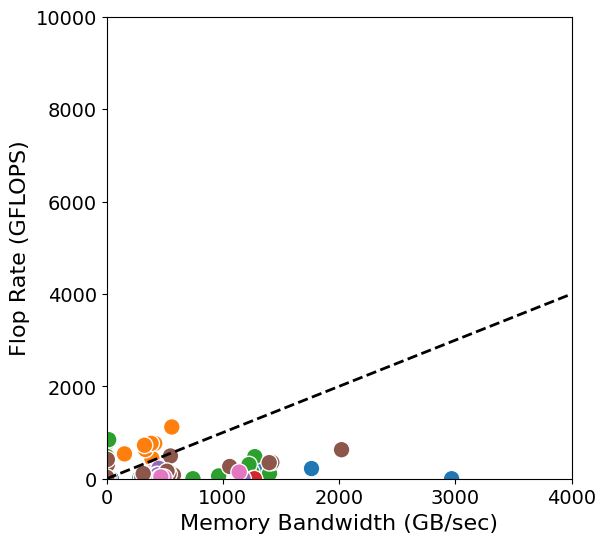

<Figure size 800x200 with 0 Axes>

In [17]:
# DDR Plot
fig_mem_v_flop_ddr, ax_mem_v_flop_ddr = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    x=mem_v_flop_df[ddr_mem_bw_mean],
    y=mem_v_flop_df[ddr_flop_rate_mean],
    hue=mem_v_flop_df[("groups", "")],
    ax=ax_mem_v_flop_ddr,
    s=4 * mpl.rcParams["lines.markersize"] ** 2,
)
ax_mem_v_flop_ddr.set_xlim(left=0, right=4000)
ax_mem_v_flop_ddr.set_ylim(bottom=0, top=10000)
ax_mem_v_flop_ddr.set_xticks([0, 1000, 2000, 3000, 4000], [0, 1000, 2000, 3000, 4000])
ax_mem_v_flop_ddr.set_xlabel("Memory Bandwidth (GB/sec)", fontsize=16)
ax_mem_v_flop_ddr.set_ylabel("Flop Rate (GFLOPS)", fontsize=16)
ax_mem_v_flop_ddr.tick_params(axis="both", which="major", labelsize=14)
plot_straight_line(ax_mem_v_flop_ddr, [0, 0], [mem_v_flop_df[ddr_mem_bw_mean].max(), mem_v_flop_df[ddr_mem_bw_mean].max()], c="k", linestyle="--", linewidth=2)
sns.move_legend(ax_mem_v_flop_ddr, "center", title="Category")

mem_v_flop_figlegend = plt.figure(figsize=(8,2))
mem_v_flop_patches, mem_v_flop_labels = ax_mem_v_flop_ddr.get_legend_handles_labels()
mem_v_flop_figlegend.legend(mem_v_flop_patches, mem_v_flop_labels, title="Kernel Group", ncols=7, fontsize=18, title_fontsize=18)
ax_mem_v_flop_ddr.get_legend().remove()

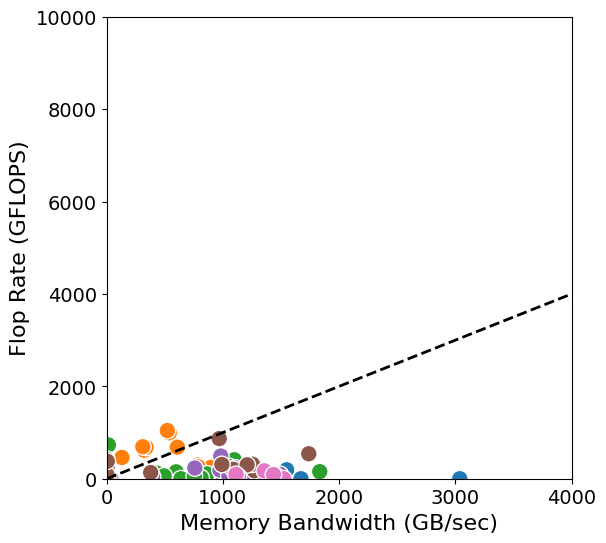

In [18]:
# HBM Plot
fig_mem_v_flop_hbm, ax_mem_v_flop_hbm = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    x=mem_v_flop_df[hbm_mem_bw_mean],
    y=mem_v_flop_df[hbm_flop_rate_mean],
    hue=mem_v_flop_df[("groups", "")],
    ax=ax_mem_v_flop_hbm,
    s=4 * mpl.rcParams["lines.markersize"] ** 2,
)
ax_mem_v_flop_hbm.set_xlim(left=0, right=4000)
ax_mem_v_flop_hbm.set_ylim(bottom=0, top=10000)
ax_mem_v_flop_hbm.set_xticks([0, 1000, 2000, 3000, 4000], [0, 1000, 2000, 3000, 4000])
ax_mem_v_flop_hbm.set_xlabel("Memory Bandwidth (GB/sec)", fontsize=16)
ax_mem_v_flop_hbm.set_ylabel("Flop Rate (GFLOPS)", fontsize=16)
ax_mem_v_flop_hbm.tick_params(axis="both", which="major", labelsize=14)
plot_straight_line(ax_mem_v_flop_hbm, [0, 0], [mem_v_flop_df[hbm_mem_bw_mean].max(), mem_v_flop_df[hbm_mem_bw_mean].max()], c="k", linestyle="--", linewidth=2)
ax_mem_v_flop_hbm.get_legend().remove()

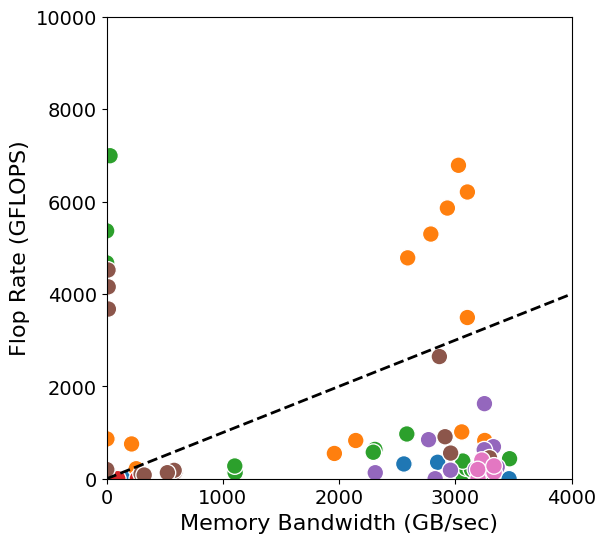

In [19]:
# V100 Plot
fig_mem_v_flop_v100, ax_mem_v_flop_v100 = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    x=mem_v_flop_df[v100_mem_bw_mean],
    y=mem_v_flop_df[v100_flop_rate_mean],
    hue=mem_v_flop_df[("groups", "")],
    ax=ax_mem_v_flop_v100,
    s=4 * mpl.rcParams["lines.markersize"] ** 2,
)
ax_mem_v_flop_v100.set_xlim(left=0, right=4000)
ax_mem_v_flop_v100.set_ylim(bottom=0, top=10000)
ax_mem_v_flop_v100.set_xticks([0, 1000, 2000, 3000, 4000], [0, 1000, 2000, 3000, 4000])
ax_mem_v_flop_v100.set_xlabel("Memory Bandwidth (GB/sec)", fontsize=16)
ax_mem_v_flop_v100.set_ylabel("Flop Rate (GFLOPS)", fontsize=16)
ax_mem_v_flop_v100.tick_params(axis="both", which="major", labelsize=14)
plot_straight_line(ax_mem_v_flop_v100, [0, 0], [mem_v_flop_df[v100_mem_bw_mean].max(), mem_v_flop_df[v100_mem_bw_mean].max()], c="k", linestyle="--", linewidth=2)
ax_mem_v_flop_v100.get_legend().remove()

[78.08415154702564, 232.7303250881792, 5027.180709278552, 7884.638183530316]
[13326.385238341536, 84113.33073775537, 11259.015340240285, 14974.466514869282]
['Basic_MAT_MAT_SHARED', 'Apps_EDGE3D', 'Apps_VOL3D', 'Apps_DIFFUSION3DPA']


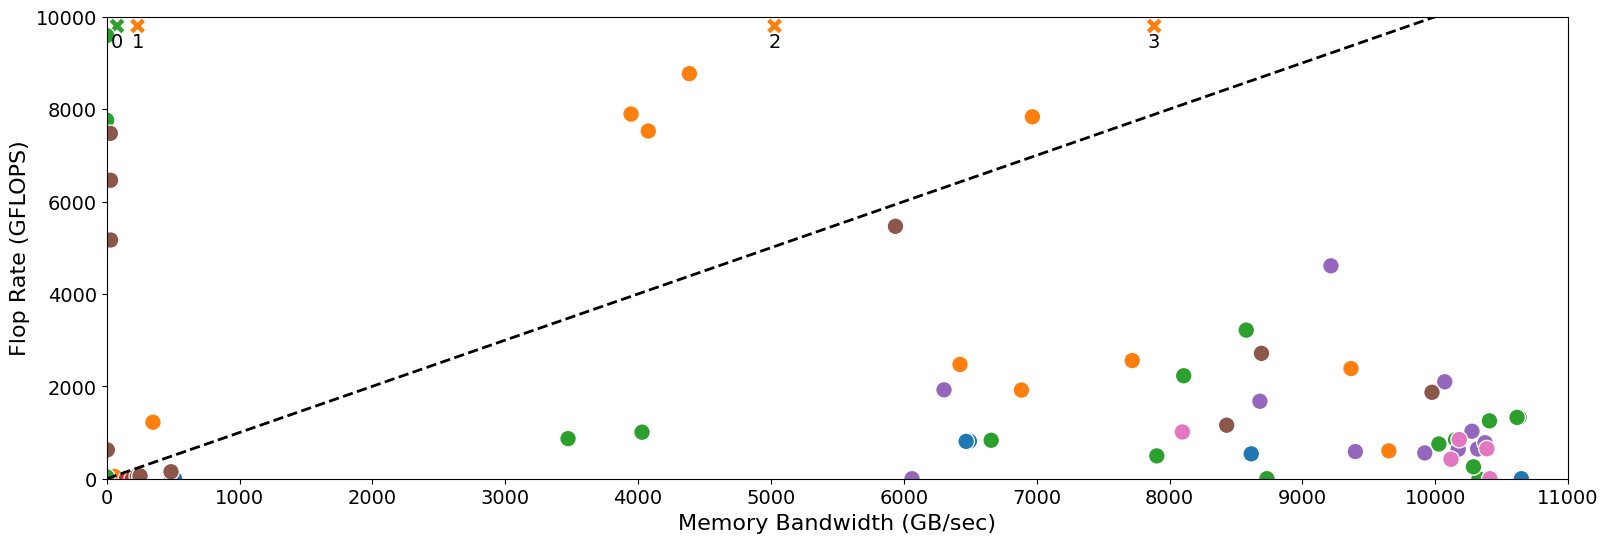

In [20]:
# MI250X Plot
fig_mem_v_flop_mi250x, ax_mem_v_flop_mi250x = plt.subplots(figsize=(6*(11000 / 3500), 6))

mi250x_ylim = 10000
mi250x_ylim_pad = 200

new_mi250x_x = mem_v_flop_df[mi250x_mem_bw_mean].tolist()
new_mi250x_y = mem_v_flop_df[mi250x_flop_rate_mean].tolist()
label_mi250x_markers = [0 for _ in range(len(new_mi250x_x))]
labels_mi250x = []
for i in range(len(new_mi250x_x)):
    y = new_mi250x_y[i]
    if y > mi250x_ylim:
        labels_mi250x.append((new_mi250x_x[i], new_mi250x_y[i], i))
        new_mi250x_y[i] = mi250x_ylim - mi250x_ylim_pad
        label_mi250x_markers[i] = 1
        
labels_mi250x = list(sorted(labels_mi250x, key=lambda tup: tup[0]))
label_mi250x_x = [tup[0] for tup in labels_mi250x]
label_mi250x_y = [tup[1] for tup in labels_mi250x]
label_mi250x_names = [tup[2] for tup in labels_mi250x]
        
label_mi250x_names = [mem_v_flop_df["name"].iloc[i] for i in label_mi250x_names]
print(label_mi250x_x)
print(label_mi250x_y)
print(label_mi250x_names)

sns.scatterplot(
    x=np.array(new_mi250x_x),  # mem_v_flop_df[mi250x_mem_bw_mean],
    y=np.array(new_mi250x_y),  # mem_v_flop_df[mi250x_flop_rate_mean],
    hue=mem_v_flop_df[("groups", "")],
    style=label_mi250x_markers,
    ax=ax_mem_v_flop_mi250x,
    s=4 * mpl.rcParams["lines.markersize"] ** 2,
)
ax_mem_v_flop_mi250x.set_xlim(left=0, right=11000)
ax_mem_v_flop_mi250x.set_ylim(bottom=0, top=mi250x_ylim) # 90000
ax_mem_v_flop_mi250x.set_xticks(list(range(0, 11001, 1000)), list(range(0, 11001, 1000)))
ax_mem_v_flop_mi250x.set_xlabel("Memory Bandwidth (GB/sec)", fontsize=16)
ax_mem_v_flop_mi250x.set_ylabel("Flop Rate (GFLOPS)", fontsize=16)
ax_mem_v_flop_mi250x.tick_params(axis="both", which="major", labelsize=14)
plot_straight_line(ax_mem_v_flop_mi250x, [0, 0], [mem_v_flop_df[mi250x_mem_bw_mean].max(), mem_v_flop_df[mi250x_mem_bw_mean].max()], c="k", linestyle="--", linewidth=2)

for i in range(len(label_mi250x_x)):
    label_pt = (label_mi250x_x[i], mi250x_ylim - 2.75*mi250x_ylim_pad)
    ax_mem_v_flop_mi250x.annotate(
        "{}".format(i),
        xy=label_pt,
        xytext=(0,0),
        fontsize=14,
        textcoords="offset points",
        ha="center",
        va="center",
    )

ax_mem_v_flop_mi250x.get_legend().remove()

### 6.2 Metric bar charts for each kernel

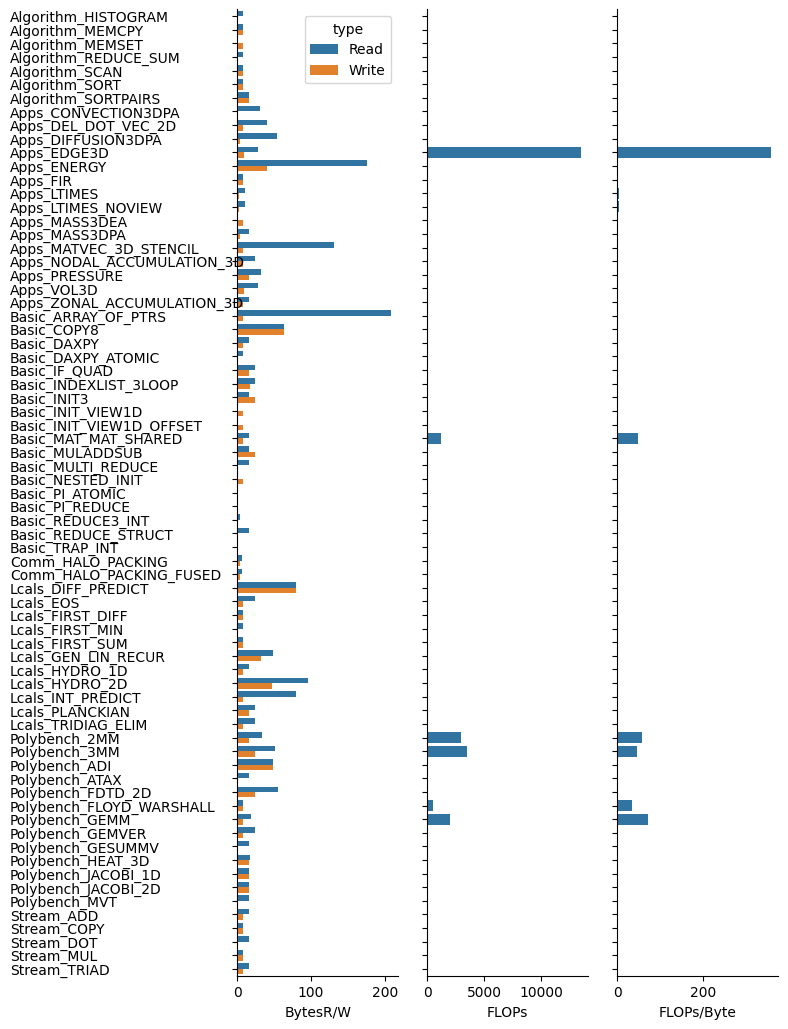

In [21]:
#analytic_metric_color_map = sns.color_palette("colorblind")

analytic_met_read_df = th.statsframe.dataframe[[
    "name",
    ddr_bytes_read_per_rep_scaled_mean,
    ddr_flops_per_rep_scaled_mean,
    ddr_flops_per_byte_mean,
]]
analytic_met_write_df = th.statsframe.dataframe[[
    "name",
    ddr_bytes_write_per_rep_scaled_mean,
    ddr_flops_per_rep_scaled_mean,
    ddr_flops_per_byte_mean,
]]
analytic_met_read_df.columns = analytic_met_read_df.columns.to_flat_index()
analytic_met_read_df.rename(
    columns={
        "name": "Kernel",
        ddr_bytes_read_per_rep_scaled_mean: "BytesR/W",
        ddr_flops_per_rep_scaled_mean: "FLOPs",
        ddr_flops_per_byte_mean: "FLOPs/Byte",
    },
    inplace=True
)
analytic_met_read_df["FLOPs/Byte"] = analytic_met_read_df["FLOPs/Byte"].apply(lambda x: x if x < 1000 else 0.0)
analytic_met_write_df.columns = analytic_met_write_df.columns.to_flat_index()
analytic_met_write_df.rename(
    columns={
        "name": "Kernel",
        ddr_bytes_write_per_rep_scaled_mean: "BytesR/W",
        ddr_flops_per_rep_scaled_mean: "FLOPs",
        ddr_flops_per_byte_mean: "FLOPs/Byte",
    },
    inplace=True
)
analytic_met_read_df["type"] = "Read"
analytic_met_write_df["type"] = "Write"
analytic_met_df = pd.concat([analytic_met_read_df, analytic_met_write_df]).reset_index(drop=True)

analytic_met_read_df["color"] = 1

pg_analytic = sns.PairGrid(
    data=analytic_met_read_df,
    y_vars=["Kernel"],
    x_vars=["BytesR/W", "FLOPs", "FLOPs/Byte"],
    despine=True,
    height=10.5,
    aspect=0.2,
    hue="color"
)
pg_analytic.tight_layout()
pg_analytic.map(sns.barplot)

pg_analytic.figure.axes[0].clear()
sns.barplot(
    data=analytic_met_df,
    y="Kernel",
    x="BytesR/W",
    hue="type",
    ax=pg_analytic.figure.axes[0],
)
pg_analytic.figure.axes[0].get_yaxis().get_label().set_visible(False)

pg_analytic_y_ax = pg_analytic.figure.axes[0].get_yaxis()
pg_analytic_y_ax.set_tick_params(pad=160)
for tick in pg_analytic_y_ax.get_majorticklabels():
    tick.set_horizontalalignment("left")

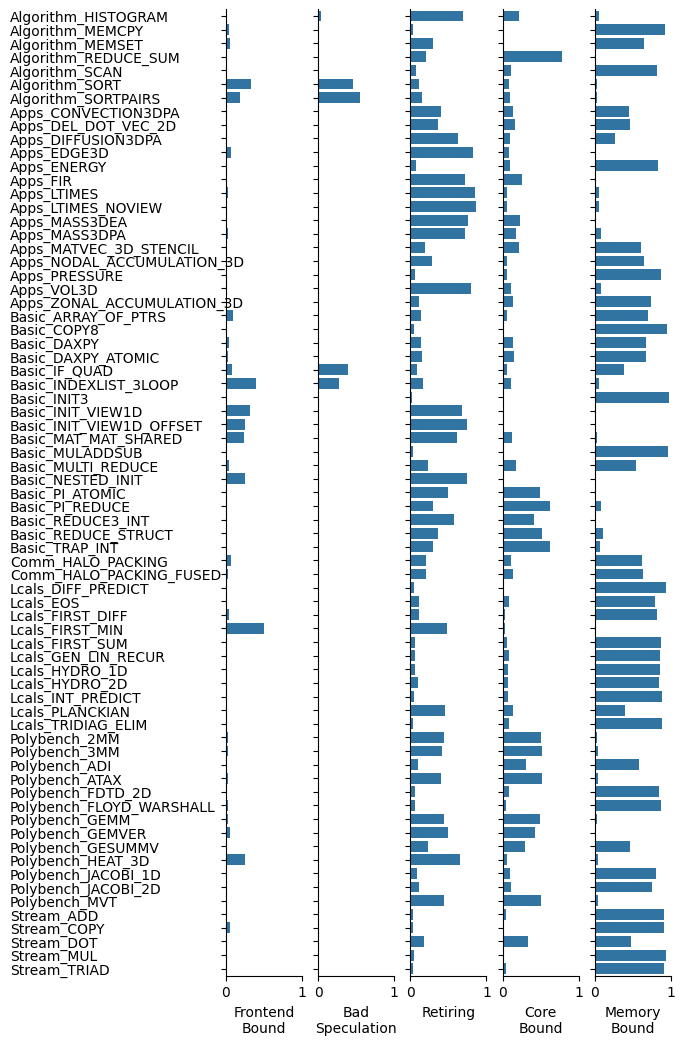

In [22]:
ddr_tma_df = th.statsframe.dataframe[[
    "name",
    ddr_fe_bound_mean,
    ddr_bad_spec_mean,
    ddr_retiring_mean,
    ddr_core_bound_mean,
    ddr_mem_bound_mean
]]
ddr_tma_df.columns = ddr_tma_df.columns.to_flat_index()
ddr_tma_df.rename(
    columns={
        "name": "Kernel",
        ddr_fe_bound_mean: "Frontend Bound",
        ddr_bad_spec_mean: "Bad Speculation",
        ddr_retiring_mean: "Retiring",
        ddr_core_bound_mean: "Core Bound",
        ddr_mem_bound_mean: "Memory Bound",
    },
    inplace=True
)

ddr_tma_df["color"] = 1

pg_ddr_tma = sns.PairGrid(
    data=ddr_tma_df,
    y_vars=["Kernel"],
    x_vars=[
        "Frontend Bound",
        "Bad Speculation",
        "Retiring",
        "Core Bound",
        "Memory Bound"
    ],
    despine=True,
    height=10.5,
    aspect=0.1,
    hue="color"
)
pg_ddr_tma.tight_layout()
pg_ddr_tma.map(sns.barplot)
pg_ddr_tma.figure.axes[0].get_yaxis().get_label().set_visible(False)
for ax in pg_ddr_tma.figure.axes:
    ax.set_xlim(0, 1)
    ax.set_xlabel(ax.get_xlabel().replace(" ", "\n"))
pg_ddr_tma_y_ax = pg_ddr_tma.figure.axes[0].get_yaxis()
pg_ddr_tma_y_ax.set_tick_params(pad=152)
for tick in pg_ddr_tma_y_ax.get_majorticklabels():
    tick.set_horizontalalignment("left")
#pg_ddr_tma.figure.savefig("figures/ddr_topdown_per_kernel.png", bbox_inches="tight", dpi=200)

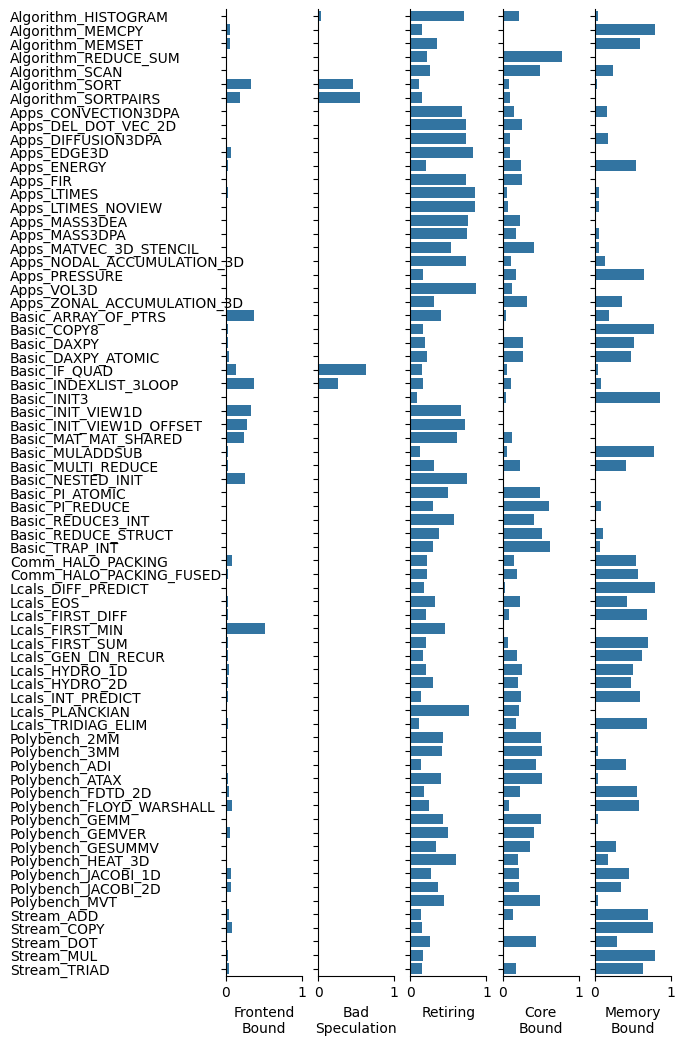

In [23]:
hbm_tma_df = th.statsframe.dataframe[[
    "name",
    # hbm_mem_bw_mean,
    # hbm_flop_rate_mean,
    hbm_fe_bound_mean,
    hbm_bad_spec_mean,
    hbm_retiring_mean,
    hbm_core_bound_mean,
    hbm_mem_bound_mean
]]
hbm_tma_df.columns = hbm_tma_df.columns.to_flat_index()
hbm_tma_df.rename(
    columns={
        "name": "Kernel",
        # hbm_mem_bw_mean: "Memory Bandwidth (GiB/s)",
        # hbm_flop_rate_mean: "FLOP Rate (GiFLOPS/s)",
        hbm_fe_bound_mean: "Frontend Bound",
        hbm_bad_spec_mean: "Bad Speculation",
        hbm_retiring_mean: "Retiring",
        hbm_core_bound_mean: "Core Bound",
        hbm_mem_bound_mean: "Memory Bound",
    },
    inplace=True
)

hbm_tma_df["color"] = 1

pg_hbm_tma = sns.PairGrid(
    data=hbm_tma_df,
    y_vars=["Kernel"],
    x_vars=[
        # "Memory Bandwidth (GiB/s)",
        # "FLOP Rate (GiFLOPS/s)",
        "Frontend Bound",
        "Bad Speculation",
        "Retiring",
        "Core Bound",
        "Memory Bound"
    ],
    despine=True,
    height=10.5,
    aspect=0.1,
    hue="color"
)
pg_hbm_tma.tight_layout()
pg_hbm_tma.map(sns.barplot)
pg_hbm_tma.figure.axes[0].get_yaxis().get_label().set_visible(False)
for ax in pg_hbm_tma.figure.axes:
    ax.set_xlim(0, 1)
    ax.set_xlabel(ax.get_xlabel().replace(" ", "\n"))
pg_hbm_tma_y_ax = pg_hbm_tma.figure.axes[0].get_yaxis()
pg_hbm_tma_y_ax.set_tick_params(pad=152)
for tick in pg_hbm_tma_y_ax.get_majorticklabels():
    tick.set_horizontalalignment("left")
#pg_hbm_tma.figure.savefig("figures/hbm_topdown_per_kernel.png", bbox_inches="tight", dpi=200)

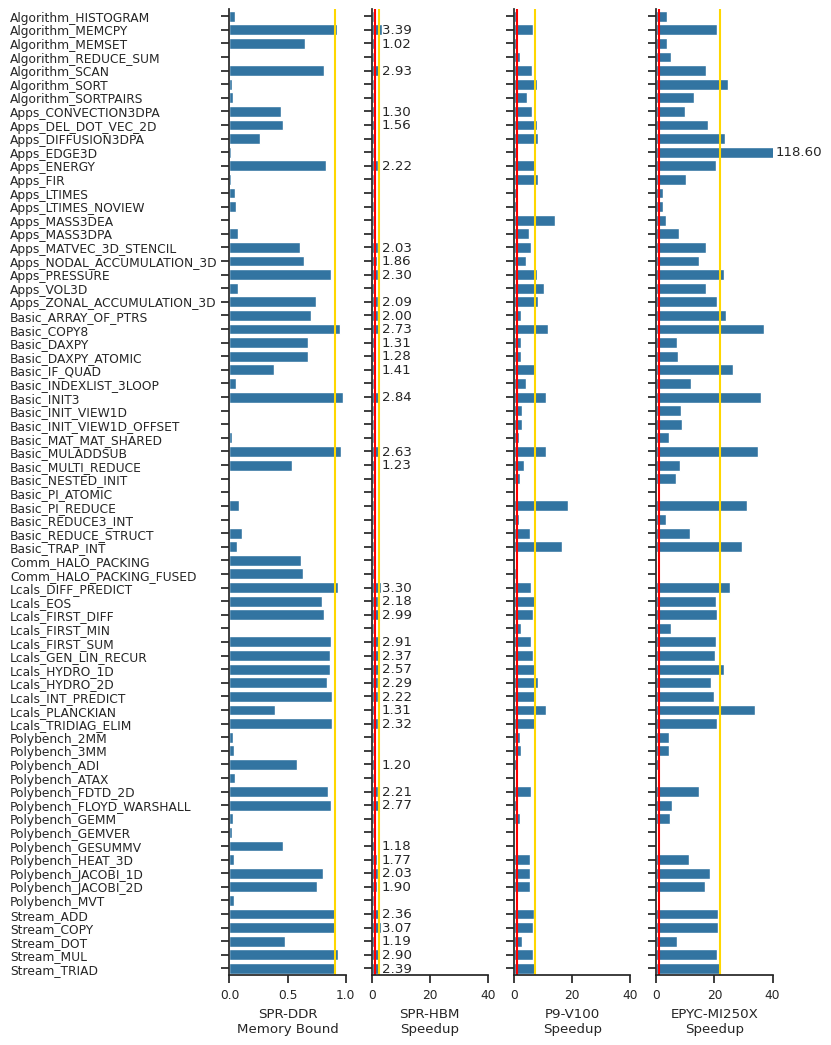

In [24]:
triple_plot_df = th.statsframe.dataframe[["name", ddr_mem_bound_mean, ddr_to_hbm_speedup, ddr_to_v100_speedup, ddr_to_mi250x_speedup]].reset_index(drop=True)
triple_plot_df.reset_index(inplace=True)

triple_plot_df.columns = triple_plot_df.columns.to_flat_index()
triple_plot_df.rename(
    columns={
        "name": "Kernel",
        ddr_mem_bound_mean: "DDR Memory Bound",
        ddr_to_hbm_speedup: "SPR-HBM Speedup",
        ddr_to_v100_speedup: "V100 Speedup",
        ddr_to_mi250x_speedup: "MI250X Speedup",
    },
    inplace=True
)

ddr_stream_copy_mem_bound = triple_plot_df[triple_plot_df["Kernel"] == "Stream_TRIAD"]["DDR Memory Bound"].iloc[0]
hbm_stream_copy_spdup = triple_plot_df[triple_plot_df["Kernel"] == "Stream_TRIAD"]["SPR-HBM Speedup"].iloc[0]
v100_stream_copy_spdup = triple_plot_df[triple_plot_df["Kernel"] == "Stream_TRIAD"]["V100 Speedup"].iloc[0]
mi250x_stream_copy_spdup = triple_plot_df[triple_plot_df["Kernel"] == "Stream_TRIAD"]["MI250X Speedup"].iloc[0]

sns.set_theme(palette="tab10", font_scale=0.8)
sns.set_style("ticks")
triple_plot_df["color"] = 1

pg_triple = sns.PairGrid(
    data=triple_plot_df,
    y_vars=["Kernel"],
    x_vars=["DDR Memory Bound", "SPR-HBM Speedup", "V100 Speedup", "MI250X Speedup"],
    despine=True,
    height=10.5,
    aspect=0.15,
    hue="color"
)
pg_triple.tight_layout()
pg_triple.map(sns.barplot)
pg_triple.figure.axes[0].set_xlim(0, 1)
pg_triple.figure.axes[0].set_xlabel("SPR-DDR\nMemory Bound")
pg_triple.figure.axes[0].get_yaxis().get_label().set_visible(False)
pg_triple.figure.axes[0].axvline(ddr_stream_copy_mem_bound, color="gold")
pg_triple.figure.axes[1].axvline(1.0, color="red")
pg_triple.figure.axes[1].axvline(hbm_stream_copy_spdup, color="gold")
pg_triple.figure.axes[1].set_xlim(0, 40)
pg_triple.figure.axes[1].set_xlabel("SPR-HBM\nSpeedup")
pg_triple.figure.axes[2].axvline(1.0, color="red")
pg_triple.figure.axes[2].axvline(v100_stream_copy_spdup, color="gold")
pg_triple.figure.axes[2].set_xlim(0, 40)
pg_triple.figure.axes[2].set_xlabel("P9-V100\nSpeedup")
pg_triple.figure.axes[3].axvline(1.0, color="red")
pg_triple.figure.axes[3].axvline(mi250x_stream_copy_spdup, color="gold")
pg_triple.figure.axes[3].set_xlim(0, 40)
pg_triple.figure.axes[3].set_xlabel("EPYC-MI250X\nSpeedup")

gpu_stream_copy_spdups = {
    "V100": v100_stream_copy_spdup,
    "MI250X": mi250x_stream_copy_spdup,
}

starting_subplot_idx = 2
            
for i, gpu_type in enumerate(["V100", "MI250X"]):
    for label in pg_triple.figure.axes[0].get_yticklabels():
        _, label_y = label.get_position()
        min_x, max_x = pg_triple.figure.axes[starting_subplot_idx+i].get_xlim()
        curr_kernel_speedup = triple_plot_df[triple_plot_df["Kernel"] == label.get_text()]["{} Speedup".format(gpu_type)].iloc[0]
        if curr_kernel_speedup > max_x:
            pg_triple.figure.axes[starting_subplot_idx+i].annotate(
                "{:.2f}".format(curr_kernel_speedup),
                xy=(max_x, label_y),
                xytext=(2, 0),
                textcoords="offset points",
                ha="left",
                va="center",
            )
starting_subplot_idx = 0         
for label in pg_triple.figure.axes[0].get_yticklabels():
    _, label_y = label.get_position()
    curr_kernel_speedup = triple_plot_df[triple_plot_df["Kernel"] == label.get_text()]["SPR-HBM Speedup"].iloc[0]
    if curr_kernel_speedup > 1:
        pg_triple.figure.axes[starting_subplot_idx+i].annotate(
            "{:.2f}".format(curr_kernel_speedup),
            xy=(2, label_y),
            xytext=(3, 0),
            textcoords="offset points",
            ha="left",
            va="center",
        )

pg_triple_y_ax = pg_triple.figure.axes[0].get_yaxis()
pg_triple_y_ax.set_tick_params(pad=152)
for tick in pg_triple_y_ax.get_majorticklabels():
    tick.set_horizontalalignment("left")

### 6.3 Analysis of kernel performance using clustering

#### 6.3A Agglomerative hierarchical clustering

In [25]:
# Try bytes/rep, flops/rep, and flops/bytes (divide by problem size first)
clustering_metrics = [
    ddr_retiring_mean,
    ddr_fe_bound_mean,
    ddr_bad_spec_mean,
    ddr_core_bound_mean,
    ddr_mem_bound_mean,
]
clustering_data = th.statsframe.dataframe.loc[:, clustering_metrics].copy(deep=True)

In [26]:
# Determine outliers based on speedup
speedup_cols = [ddr_to_mi250x_speedup, ddr_to_v100_speedup, ddr_to_hbm_speedup]

for spdp in speedup_cols:
    # calculate z score for that column
    z = np.abs(stats.zscore(th.statsframe.dataframe[spdp]))
    # 3 is the typical z score threshold 
    outlier_indices = np.where(z > 3)[0]
    # if there is at least one outlier print the name
    if len(outlier_indices) > 0:    
        print(th.statsframe.dataframe.iloc[[outlier_indices[0]]].name.unique())

['Apps_EDGE3D']
['Basic_PI_REDUCE']


In [27]:
# We need to filter non O(n) complexity kernels (listed in the table 1 in the paper) as well as outliers based on speedup identified in cell above
Non_On_kernels = [
    "Algorithm_SORT",
    "Algorithm_SORTPAIRS",
    "Comm_HALO_EXCHANGE",
    "Comm_HALO_EXCHANGE_FUSED",
    "Comm_HALO_PACKING",
    "Comm_HALO_PACKING_FUSED",
    "Comm_HALO_SENDRECV",
    "Polybench_2MM",
    "Polybench_3MM" ,
    "Polybench_FLOYD_WARSHALL",
    "Polybench_GEMM",
    "Apps_EDGE3D",
    "Basic_PI_REDUCE",
]

clustering_data["name"] = [n.frame["name"] for n in clustering_data.index]
clustering_data = clustering_data[~clustering_data["name"].isin(Non_On_kernels)]
clustering_data = clustering_data.drop(columns=["name"])
# Filter from statsframe
th.statsframe.dataframe = th.statsframe.dataframe[~th.statsframe.dataframe["name"].isin(Non_On_kernels)]

In [28]:
thresh = 1.4
cluster_op = sk.AgglomerativeClustering(linkage="ward", distance_threshold=thresh, n_clusters=None, compute_full_tree=True)
th.statsframe.dataframe[("label", "")] = cluster_op.fit_predict(clustering_data)

cluster_summary_df = th.statsframe.dataframe[["name", *clustering_metrics, ddr_to_hbm_speedup, ddr_to_v100_speedup, ddr_to_mi250x_speedup, ("label", "")]].reset_index(drop=True)
cluster_summary_df.columns = cluster_summary_df.columns.to_flat_index()
cluster_summary_df.rename(
    columns={
        "name": "Kernel",
        ddr_fe_bound_mean: "Frontend Bound",
        ddr_bad_spec_mean: "Bad Speculation",
        ddr_retiring_mean: "Retiring",
        ddr_core_bound_mean: "Core Bound",
        ddr_mem_bound_mean: "Memory Bound",
        ddr_to_hbm_speedup: "Speedup on SPR-HBM",
        ddr_to_v100_speedup: "Speedup on P9-V100",
        ddr_to_mi250x_speedup: "Speedup on EPYC-MI250X",
        ("label", ""): "Cluster ID",
    },
    inplace=True
)
cluster_summary_df

,Kernel,Retiring,Frontend Bound,Bad Speculation,Core Bound,Memory Bound,Speedup on SPR-HBM,Speedup on P9-V100,Speedup on EPYC-MI250X,Cluster ID
0,Algorithm_HISTOGRAM,0.690707,0.010253,0.035223,0.214034,0.049784,0.878386,1.448340,3.684487,1
1,Algorithm_MEMCPY,0.034130,0.036830,0.000045,0.006275,0.922720,3.386796,6.473918,21.017597,2
2,Algorithm_MEMSET,0.299764,0.052811,0.000090,0.000392,0.646944,1.023321,1.166566,3.588471,0
3,Algorithm_REDUCE_SUM,0.208152,0.003664,0.000258,0.780477,0.007449,0.863619,2.139605,4.882868,3
4,Algorithm_SCAN,0.067790,0.007750,0.000087,0.112851,0.811522,2.927147,6.201060,17.215451,2
...,...,...,...,...,...,...,...,...,...,...
56,Stream_ADD,0.035294,0.004228,0.000086,0.045098,0.915294,2.362050,6.953190,21.112355,2
57,Stream_COPY,0.036062,0.047398,0.000034,0.006661,0.909846,3.074465,6.459098,21.052661,2
58,Stream_DOT,0.181774,0.007289,0.000165,0.336867,0.473905,1.188229,2.831148,7.101520,0
59,Stream_MUL,0.043580,0.009357,0.000064,0.012957,0.934042,2.902520,6.459979,21.022930,2


#### 6.3B Dendrogram Visualization of Clusters

In [29]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, **kwargs)

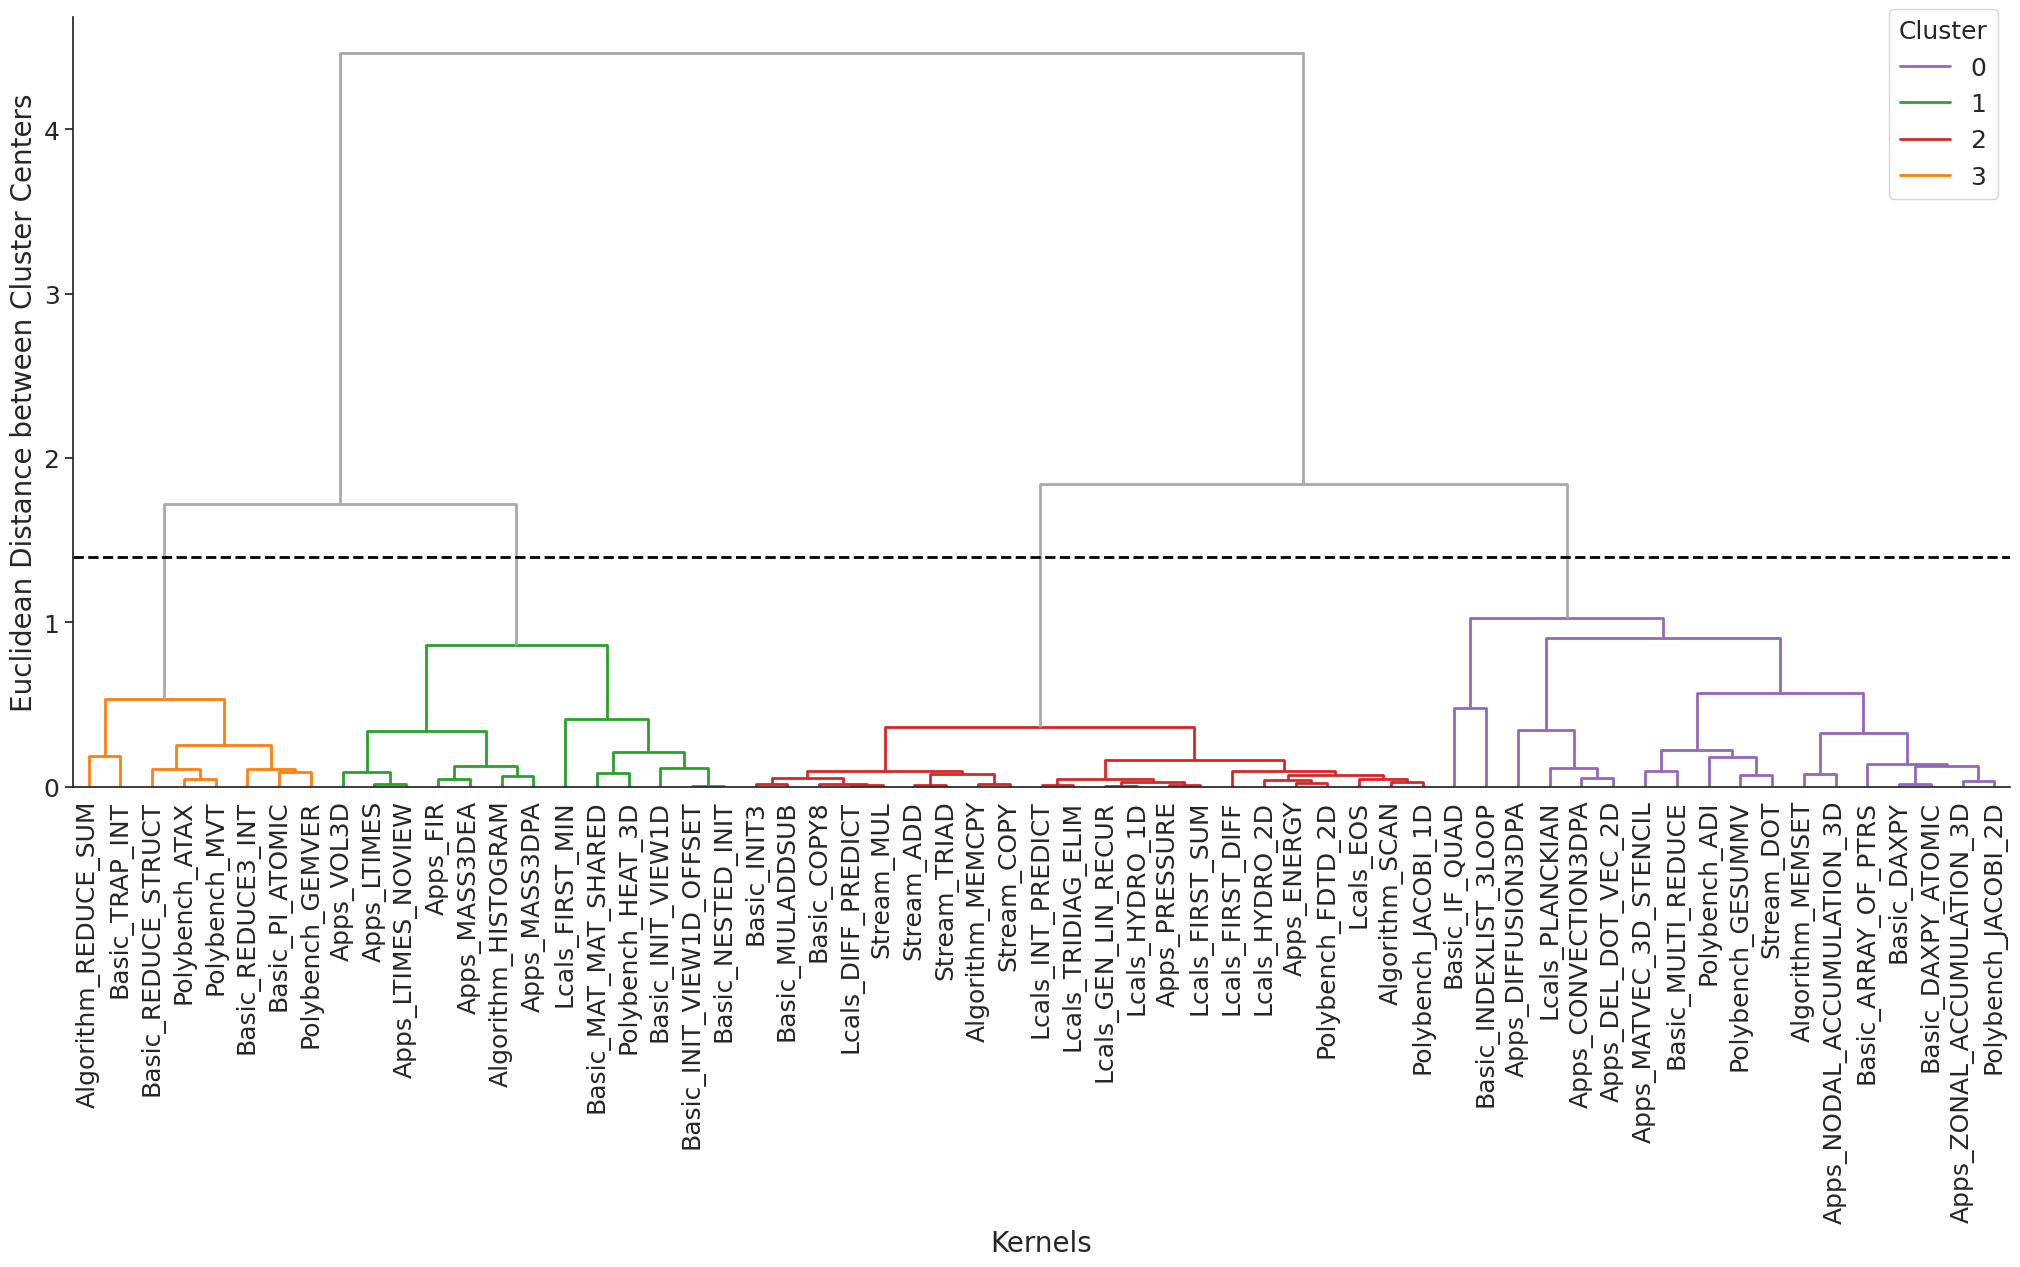

In [30]:
dendro_fig, dendro_ax = plt.subplots(figsize=(25, 10))

with plt.rc_context({"lines.linewidth": 2}):
    dendro_dict = plot_dendrogram(
        cluster_op,
        ax=dendro_ax,
        color_threshold=thresh,
        labels=th.statsframe.dataframe["name"],
        above_threshold_color="darkgray",
    )

    dendro_colors = {th.statsframe.dataframe[("label", "")].iloc[l]: c for l, c in zip(dendro_dict["leaves"], dendro_dict["leaves_color_list"])}
    dendro_labels = list(sorted([l for l in dendro_colors.keys()]))
    dendro_handles = []
    for label in dendro_labels:
        dendro_handles.append(plt.Line2D([0], [0], color=dendro_colors[label]))

    dendro_fig.legend(
        dendro_handles,
        dendro_labels,
        title="Cluster",
        loc="upper right",
        bbox_to_anchor=(0.9, 0.9),
        title_fontsize=18,
        fontsize=18,
    )
    dendro_ax.axhline(thresh, color="k", linestyle="--")

dendro_ax.spines[["right", "top"]].set_visible(False)
dendro_ax.set_ylabel("Euclidean Distance between Cluster Centers", fontsize=20)
dendro_ax.set_xlabel("Kernels", fontsize=20)
dendro_ax.tick_params(axis="both", which="major", labelsize=18)

#dendro_fig.savefig("figures/clustering_dendrogram.png", bbox_inches="tight", dpi=200)

#### 6.3C Categorical plot showing the makeup of each cluster

In [31]:
tma_metric_dfs = []
for m in ["Retiring", "Frontend Bound", "Bad Speculation", "Core Bound", "Memory Bound"]:
    single_tma_metric_df = cluster_summary_df[["Kernel", m, "Cluster ID"]]
    single_tma_metric_df.rename(columns={m: "TMA Metric"}, inplace=True)
    single_tma_metric_df["type"] = m
    tma_metric_dfs.append(single_tma_metric_df)

clustering_plotting_metric_df = pd.concat(tma_metric_dfs)

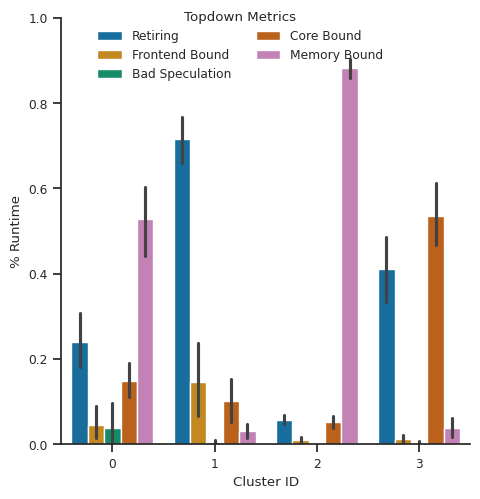

In [32]:
fg_cluster_summary = sns.catplot(
    data=clustering_plotting_metric_df,
    x="Cluster ID",
    y="TMA Metric",
    hue="type",
    kind="bar",
    palette="colorblind",
)
fg_cluster_summary.ax.set_ylabel("% Runtime")
# fg_cluster_summary.legend.set_title("Topdown Metrics")
# fg_cluster_summary.legend.set_ncols(5)
fg_cluster_summary.ax.set_ylim(bottom=0, top=1)
sns.move_legend(fg_cluster_summary, "upper center", title="Topdown Metrics", ncols=2)

#### 6.3D Parallel Coordinate Plots

Note: these plots are created with the plotly library which may require updates to your jupyter environment, and they will not render in LLNL's LC jupyter environment

If experiencing rendering issues, try the following command followed by restarting the kernel.
```
pip install --upgrade nbformat
```

In [33]:
# Grab just the relevant metrics from above  and flatten for parallel coordinate plots
relevant_metrics_df = th.statsframe.dataframe[[
    "name",
    ddr_fe_bound_mean,
    ddr_bad_spec_mean,
    ddr_retiring_mean,
    ddr_core_bound_mean,
    ddr_mem_bound_mean,
    ddr_to_hbm_speedup,
    ddr_to_v100_speedup,
    ddr_to_mi250x_speedup,
    ("label", ""),
]].copy(deep=True)
relevant_metrics_df.columns = relevant_metrics_df.columns.to_flat_index()
relevant_metrics_df.rename(
    columns={
        "name": "Kernel",
        ddr_fe_bound_mean: "Frontend Bound",
        ddr_bad_spec_mean: "Bad Speculation",
        ddr_retiring_mean: "Retiring",
        ddr_core_bound_mean: "Core Bound",
        ddr_mem_bound_mean: "Memory Bound",
        ddr_to_hbm_speedup: "Speedup on SPR-HBM",
        ddr_to_v100_speedup: "Speedup on P9-V100",
        ddr_to_mi250x_speedup: "Speedup on EPYC-MI250X",
        ("label", ""): "Cluster ID",
    },
    inplace=True,
)
relevant_metrics_df.reset_index(inplace=True, drop=True)
relevant_metrics_df.sort_values(by="Kernel", inplace=True)
relevant_metrics_df

,Kernel,Frontend Bound,Bad Speculation,Retiring,Core Bound,Memory Bound,Speedup on SPR-HBM,Speedup on P9-V100,Speedup on EPYC-MI250X,Cluster ID
0,Algorithm_HISTOGRAM,0.010253,0.035223,0.690707,0.214034,0.049784,0.878386,1.448340,3.684487,1
1,Algorithm_MEMCPY,0.036830,0.000045,0.034130,0.006275,0.922720,3.386796,6.473918,21.017597,2
2,Algorithm_MEMSET,0.052811,0.000090,0.299764,0.000392,0.646944,1.023321,1.166566,3.588471,0
3,Algorithm_REDUCE_SUM,0.003664,0.000258,0.208152,0.780477,0.007449,0.863619,2.139605,4.882868,3
4,Algorithm_SCAN,0.007750,0.000087,0.067790,0.112851,0.811522,2.927147,6.201060,17.215451,2
...,...,...,...,...,...,...,...,...,...,...
56,Stream_ADD,0.004228,0.000086,0.035294,0.045098,0.915294,2.362050,6.953190,21.112355,2
57,Stream_COPY,0.047398,0.000034,0.036062,0.006661,0.909846,3.074465,6.459098,21.052661,2
58,Stream_DOT,0.007289,0.000165,0.181774,0.336867,0.473905,1.188229,2.831148,7.101520,0
59,Stream_MUL,0.009357,0.000064,0.043580,0.012957,0.934042,2.902520,6.459979,21.022930,2


In [34]:
# Get the averages
avg_no_outliers = relevant_metrics_df.set_index("Kernel").groupby("Cluster ID", as_index=False).mean()
avg_no_outliers.head()

,Cluster ID,Frontend Bound,Bad Speculation,Retiring,Core Bound,Memory Bound,Speedup on SPR-HBM,Speedup on P9-V100,Speedup on EPYC-MI250X
0,0,0.045162,0.038030,0.240191,0.148751,0.527868,1.428587,4.719687,13.982355
1,1,0.145991,0.005019,0.716902,0.102064,0.030025,0.955922,4.550998,7.054327
2,2,0.010309,0.000069,0.056159,0.052239,0.881230,2.597233,7.357837,22.648322
3,3,0.011847,0.003712,0.411688,0.535751,0.037015,0.865081,3.359616,6.260869


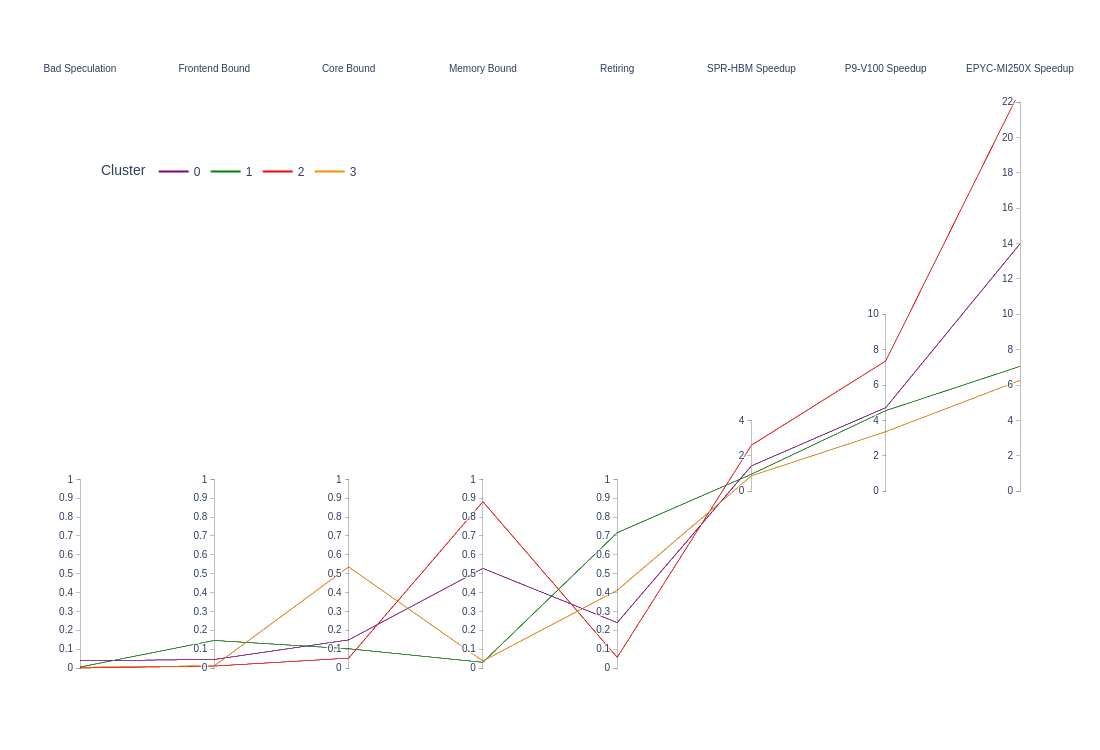

In [35]:
fig = go.Figure(data=
    [
    go.Parcoords(
        line = dict(color = avg_no_outliers["Cluster ID"],
                   colorscale = [[0, "purple"], [0.33, "green"], [0.66, "red"], [1, "darkorange"],]),
        dimensions = list([
            dict(range = [0,3],
                 tickvals = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                label = "Bad Speculation", values = avg_no_outliers["Bad Speculation"]),
            dict(range = [0,3],
                 tickvals = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                label = "Frontend Bound", values = avg_no_outliers["Frontend Bound"]),
            dict(range = [0,3],
                 tickvals = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                label = "Core Bound", values = avg_no_outliers["Core Bound"]),
            dict(range = [0,3],
                 tickvals = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                label = "Memory Bound", values = avg_no_outliers["Memory Bound"]),
            dict(range = [0,3],
                 tickvals = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                label = "Retiring", values = avg_no_outliers["Retiring"]),
            dict(range = [-10,22],
                 tickvals = [0,2,4,],
                label = "SPR-HBM Speedup", values = avg_no_outliers["Speedup on SPR-HBM"]),
            dict(range = [-10,22],
                 tickvals = [0,2,4,6,8,10],
                label = "P9-V100 Speedup", values = avg_no_outliers["Speedup on P9-V100"]),
            dict(range = [-10,22],
                 tickvals = [0,2,4,6,8,10,12,14,16,18,20,22],
                label = "EPYC-MI250X Speedup", values = avg_no_outliers["Speedup on EPYC-MI250X"])
        ])
    ),
    #Custom Legend
    go.Scatter(
            x=[None],
            y=[None],
            mode="lines",
            name="0",
            marker=dict(size=7, color="purple", ),
        ),

        go.Scatter(
            x=[None],
            y=[None],
            mode="lines",
            name="1",
            marker=dict(size=7, color="green", ),
        ),

        go.Scatter(
            x=[None],
            y=[None],
            mode="lines",
            name="2",
            marker=dict(size=7, color="red",),
        ),
        go.Scatter(
            x=[None],
            y=[None],
            mode="lines",
            name="3",
            marker=dict(size=7, color="darkorange",),
        ),               
    ]   
)

fig.update_layout(
    width=1100, height=750,
    plot_bgcolor = "white",
    paper_bgcolor = "white"
)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    legend=dict(
        title="Cluster",
        orientation="h",
        yanchor="auto",
        y=0.9,
        xanchor="right",
        x=0.3
    )
)

#fig.write_image("images/par_coord_AVG_NO_OUTLIERS.png")

#fig.show() # <- For interactive plot
fig.show(renderer="png") # <- For static plot

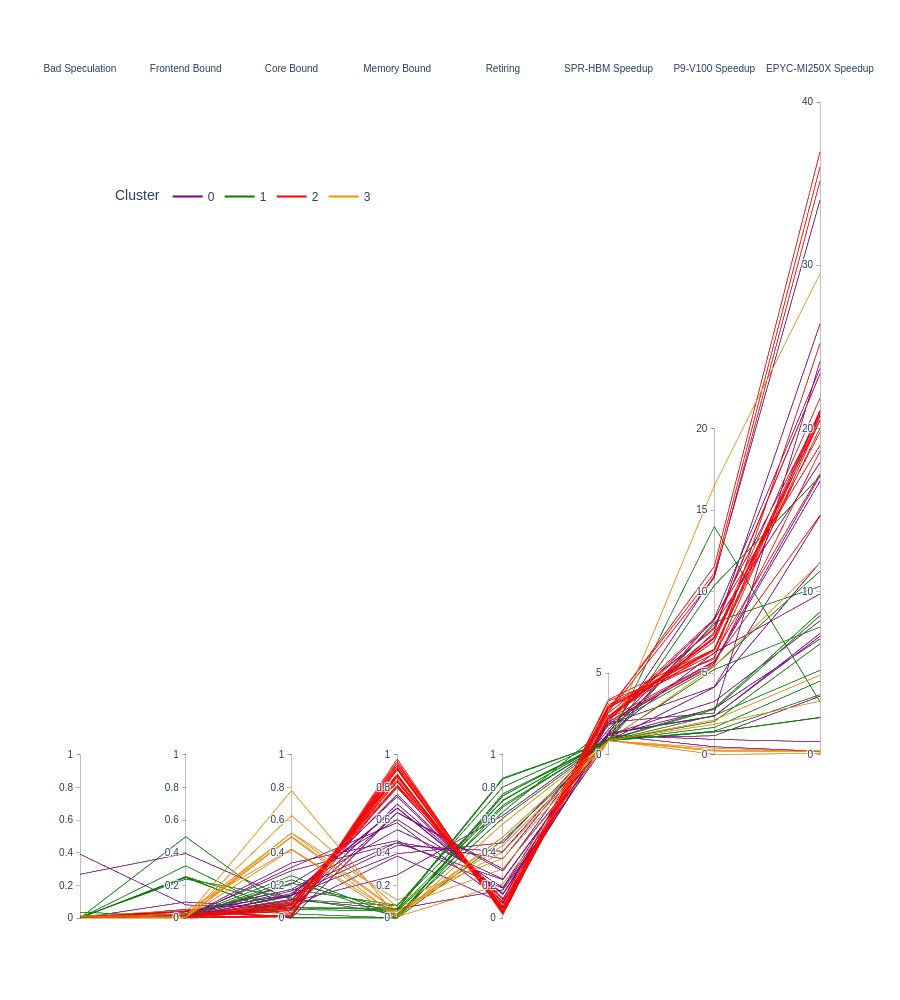

In [36]:
# plot all kernels
fig = go.Figure(data=
    [
        go.Parcoords(
            line = dict(
                color = relevant_metrics_df["Cluster ID"], 
                colorscale = [[0, "purple"], [0.33, "green"], [0.66, "red"], [1, "darkorange"],]
            ),
            dimensions = list([
                dict(
                    range = [0, 5],
                    tickvals = [0, 0.2, 0.4, 0.6, 0.8, 1],
                    label = "Bad Speculation",
                    values = relevant_metrics_df["Bad Speculation"],
                ),
                dict(
                    range = [0, 5],
                    tickvals = [0, 0.2, 0.4, 0.6, 0.8, 1],
                    label = "Frontend Bound",
                    values = relevant_metrics_df["Frontend Bound"],
                ),
                dict(
                    range = [0, 5],
                    tickvals = [0, 0.2, 0.4, 0.6, 0.8, 1],
                    label = "Core Bound",
                    values = relevant_metrics_df["Core Bound"],
                ),
                dict(
                    range = [0, 5],
                    tickvals = [0, 0.2, 0.4, 0.6, 0.8, 1],
                    label = "Memory Bound",
                    values = relevant_metrics_df["Memory Bound"],
                ),
                dict(
                    range = [0, 5],
                    tickvals = [0, 0.2, 0.4, 0.6, 0.8, 1],
                    label = "Retiring",
                    values = relevant_metrics_df["Retiring"],
                ),
                dict(
                    range = [-10, 40],
                    tickvals = [0, 5],
                    label = "SPR-HBM Speedup",
                    values = relevant_metrics_df["Speedup on SPR-HBM"],
                ),
                dict(
                    range = [-10, 40],
                    tickvals = [0, 5, 10, 15, 20],
                    label = "P9-V100 Speedup",
                    values = relevant_metrics_df["Speedup on P9-V100"],
                ),
                dict(
                    range = [-10, 40],
                    tickvals = [0, 10, 20, 30, 40],
                    label = "EPYC-MI250X Speedup",
                    values = relevant_metrics_df["Speedup on EPYC-MI250X"],
                )
            ])
        ),
        #Custom Legend
        go.Scatter(
            x=[None],
            y=[None],
            mode="lines",
            name="0",
            marker=dict(size=7, color="purple"),
        ),

        go.Scatter(
            x=[None],
            y=[None],
            mode="lines",
            name="1",
            marker=dict(size=7, color="green"),
        ),

        go.Scatter(
            x=[None],
            y=[None],
            mode="lines",
            name="2",
            marker=dict(size=7, color="red"),
        ),
        go.Scatter(
            x=[None],
            y=[None],
            mode="lines",
            name="3",
            marker=dict(size=7, color="darkorange"),
        ),                    
    ]   
)

fig.update_layout(
    width=900,
    height=1000,
    plot_bgcolor = "white",
    paper_bgcolor = "white",
)

fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    legend=dict(
        title="Cluster",
        orientation="h",
        yanchor="auto",
        y=0.9,
        xanchor="right",
        x=0.4,
    )
)

#fig.write_image("images/par_coord_NO_OUTLIERS.png")

#fig.show() # <- For interactive plot
fig.show(renderer="png") # <- For static plot